**Загрузка данных**

In [ ]:
!pip install finam-export

In [ ]:
#Загружаем библиотеки

import pandas as pd #Пандас
import matplotlib.pyplot as plt #Отрисовка графиков
import numpy as np #Numpy
import os
import random
import time
from IPython.display import clear_output
from tqdm import tqdm

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model 
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, LSTM, GlobalMaxPooling1D,MaxPooling1D, Activation, Reshape
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import keras.backend as K
from tensorflow.keras.callbacks import LambdaCallback,ReduceLROnPlateau,EarlyStopping,ModelCheckpoint
from keras.models import load_model
from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import AUC, MAE
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model

from sklearn import utils
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.externals import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, classification_report, confusion_matrix,roc_auc_score, roc_curve, precision_recall_fscore_support, f1_score

from scipy import stats

import logging

from finam import Exporter, Market, LookupComparator, Timeframe
from finam.utils import click_validate_enum

import seaborn as sns

%matplotlib inline

pd.options.mode.chained_assignment = None

/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Получаем входные данные

In [ ]:
# Get data of stock
file_name = 'Trading_NET_v3_3'
exporter = Exporter()
ticker = exporter.lookup(market=Market.USA, name='Microsoft',
                          name_comparator=LookupComparator.CONTAINS)
assert len(ticker) == 1
data_initial = exporter.download(ticker.index[0], market=Market.USA, timeframe=Timeframe.HOURLY)
data = data_initial.copy()
data = data.iloc[:,2:]
data.reset_index(inplace=True, drop=True)
data

<OPEN>  <HIGH>     <LOW>   <CLOSE>     <VOL>
0       29.91   30.01   29.8499   29.8500   7409675
1       29.85   30.05   29.8300   29.9500  10113135
2       29.95   30.13   29.9300   30.0850   6752946
3       30.08   30.25   30.0500   30.1799   5903632
4       30.18   30.21   30.1000   30.1600   6269579
...       ...     ...       ...       ...       ...
25380  247.89  248.63  247.6800  248.3300    123029
25381  248.34  248.37  247.8300  248.0400     76124
25382  248.00  248.27  247.7100  248.2700     71665
25383  248.26  248.47  248.0200  248.4300     76152
25384  248.43  248.44  246.9600  247.3900    272558

[25385 rows x 5 columns]

# Подготовка данных

In [ ]:
xlen = 120  # How many candles to take in window
batch_size = 512
forward_lag = 5  # Steps forward to look
flat = 0.01  # Limit of flat moving
col = data.columns.tolist()
price_columns = col[:-1]  # Create list of price columns names
volume_column = col[-1]  # Column with volume
data


<OPEN>  <HIGH>     <LOW>   <CLOSE>     <VOL>
0       29.91   30.01   29.8499   29.8500   7409675
1       29.85   30.05   29.8300   29.9500  10113135
2       29.95   30.13   29.9300   30.0850   6752946
3       30.08   30.25   30.0500   30.1799   5903632
4       30.18   30.21   30.1000   30.1600   6269579
...       ...     ...       ...       ...       ...
25380  247.89  248.63  247.6800  248.3300    123029
25381  248.34  248.37  247.8300  248.0400     76124
25382  248.00  248.27  247.7100  248.2700     71665
25383  248.26  248.47  248.0200  248.4300     76152
25384  248.43  248.44  246.9600  247.3900    272558

[25385 rows x 5 columns]

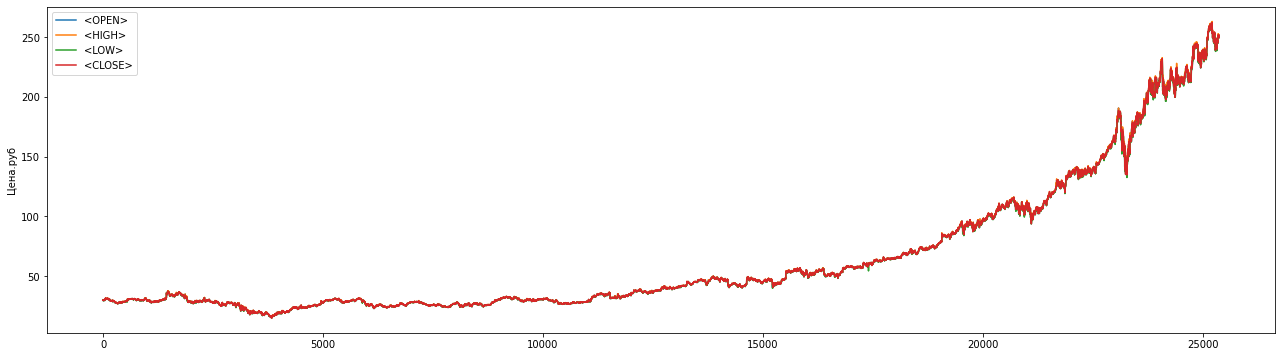

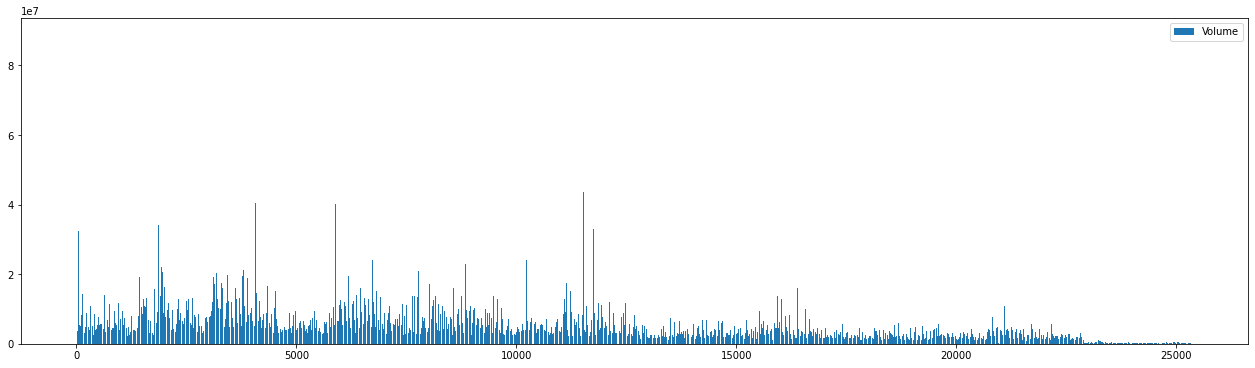

In [ ]:
# Draw the data in channels
plt.figure(figsize=(22,6))
for i in range(4):
  plt.plot(data.iloc[:,i], 
          label=col[i])
plt.ylabel('Цена.руб')
plt.legend()
plt.show()

#Chanel volume
plt.figure(figsize=(22,6))
plt.bar(x=data.index, height=data.iloc[:,4], label="Volume")
plt.legend()
plt.show()

In [ ]:
# Split dataset to train and test. Test 20%
test_len = data.shape[0] - int(data.shape[0]*0.2)
data_test = data.iloc[test_len:]
data_train_initial = data.iloc[:test_len]
data_train = data_train_initial.copy(deep=True)
data_train_down = data_train_initial.copy(deep=True)

# Create target to up move
def target(df):
  pd.options.mode.chained_assignment = None
  df['Y'] = 0
  for i in range(1,forward_lag+1):
    column_name_up = 'Y%d'%(i)
    df[column_name_up] = df['<HIGH>'].shift(-i)
    df.loc[((df[column_name_up] - df['<CLOSE>']) / df['<CLOSE>']) >= (0+flat), column_name_up] = 1
    df.loc[df[column_name_up] != 1, column_name_up] = 0
    df.loc[df[column_name_up] != 0, 'Y'] = 1
    del df[column_name_up]
  
  df['Y'] = df['Y'].shift(1)  # It is necessary to apply later keras.timeseries generator
  
  for c in price_columns:
    df[c]=df[c].pct_change()

  df.dropna(axis=0, how = 'any',inplace=True)

  return df

# Create target to down move
def target_down(df):
  pd.options.mode.chained_assignment = None
  df['Y'] = 0
  for i in range(1,forward_lag+1):
    column_name_up = 'Y%d'%(i)
    df[column_name_up] = df['<CLOSE>'].shift(-i)
    df.loc[((df[column_name_up] - df['<CLOSE>']) / df['<CLOSE>']) <= (0-flat/2), column_name_up] = 1
    df.loc[df[column_name_up] != 1, column_name_up] = 0
    df.loc[df[column_name_up] != 0, 'Y'] = 1
    del df[column_name_up]

  df['Y'] = df['Y'].shift(1)  # It is necessary to apply later keras.timeseries generator

  for c in price_columns:
    df[c]=df[c].pct_change()

  df.dropna(axis=0, how = 'any',inplace=True)

  return df

# Apply target functions
data_train = target(data_train)
print(data_train)
data_train_down = target_down(data_train_down)
print(data_train_down)

         <OPEN>    <HIGH>     <LOW>   <CLOSE>     <VOL>    Y
1     -0.002006  0.001333 -0.000667  0.003350  10113135  1.0
2      0.003350  0.002662  0.003352  0.004508   6752946  1.0
3      0.004341  0.003983  0.004009  0.003154   5903632  0.0
4      0.003324 -0.001322  0.001664 -0.000659   6269579  0.0
5     -0.000663 -0.000331 -0.023256 -0.022215  11081517  0.0
...         ...       ...       ...       ...       ...  ...
20303  0.002423  0.005989  0.002958  0.007156   2541963  0.0
20304  0.007011  0.002496  0.005174 -0.000720   2468961  0.0
20305 -0.000588 -0.000527  0.001251  0.001057   1557660  0.0
20306  0.001020  0.000240  0.000000  0.000288   1756581  0.0
20307  0.000192 -0.000862 -0.001826 -0.000480   4320814  0.0

[20307 rows x 6 columns]
         <OPEN>    <HIGH>     <LOW>   <CLOSE>     <VOL>    Y
1     -0.002006  0.001333 -0.000667  0.003350  10113135  1.0
2      0.003350  0.002662  0.003352  0.004508   6752946  1.0
3      0.004341  0.003983  0.004009  0.003154   5903632  1.

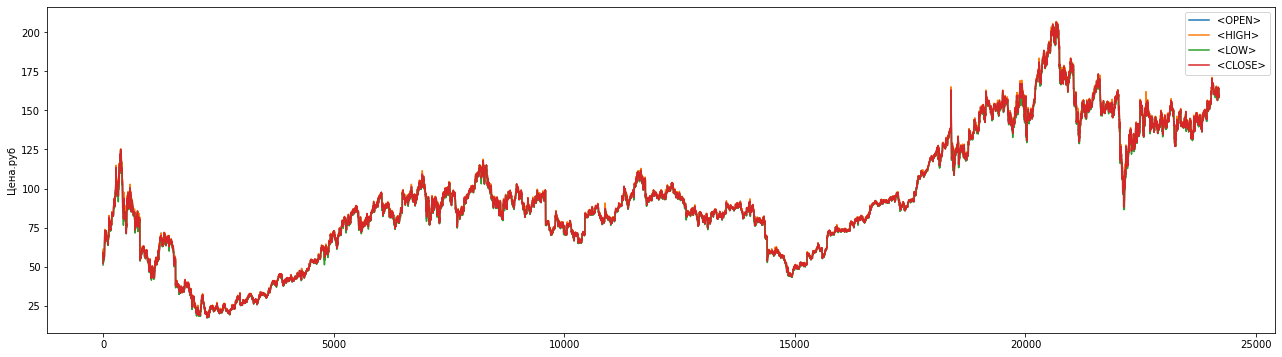

In [ ]:
# Here is the code to check data of stock manualy. Launch only if need to check any new ticker
# Get data of stock
ticker_data = exporter.lookup(market=Market.USA, code='VMW',
                          name_comparator=LookupComparator.CONTAINS)
assert len(ticker_data) == 1
df = exporter.download(ticker_data.index[0], market=Market.USA, timeframe=Timeframe.HOURLY)
df = df.iloc[:,2:]
df.reset_index(inplace=True, drop=True)

# Draw the data in channels
plt.figure(figsize=(22,6))
for i in range(4):
  plt.plot(df.iloc[:,i], 
          label=col[i])
plt.ylabel('price')
plt.legend()
plt.show()

In [ ]:
ticker_data = exporter.lookup(market=Market.USA, code='CRWD',
                              name_comparator=LookupComparator.CONTAINS)
print(ticker_data)

                               name  code  market
id                                               
1948304  CrowdStrike Holdings, Inc.  CRWD      25


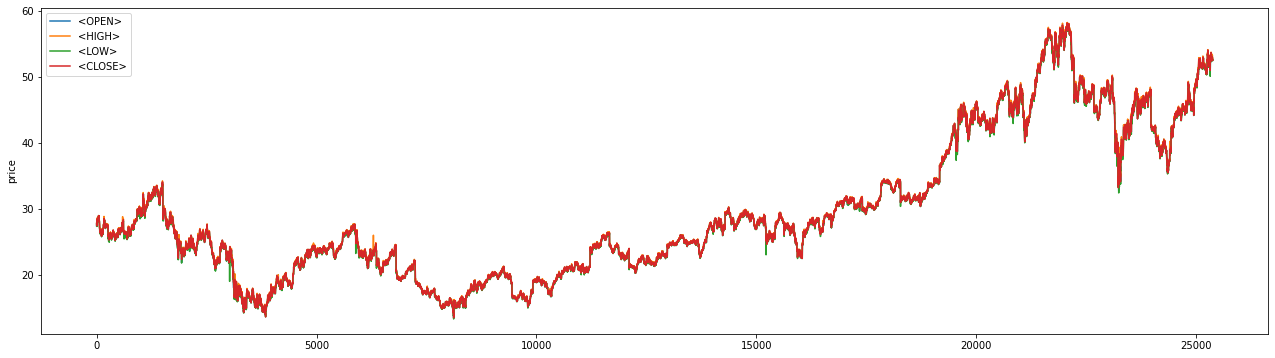

CSCO (25374, 5)


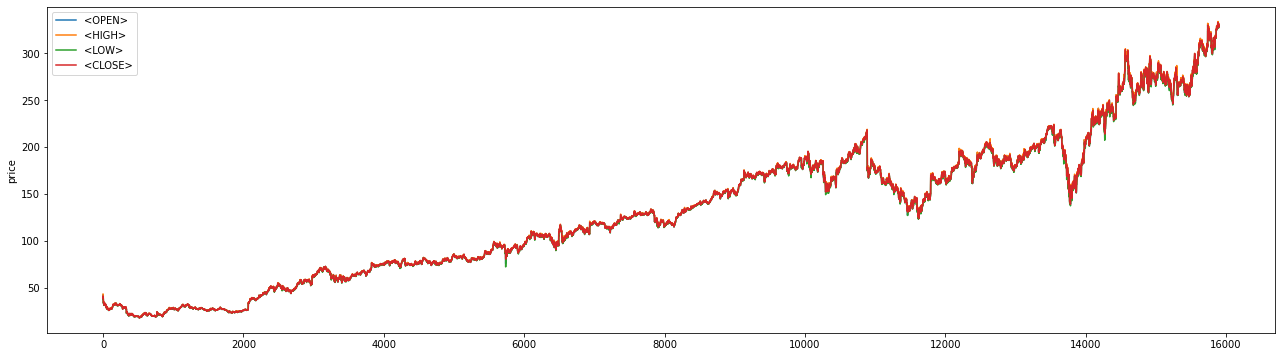

FB (15901, 5)


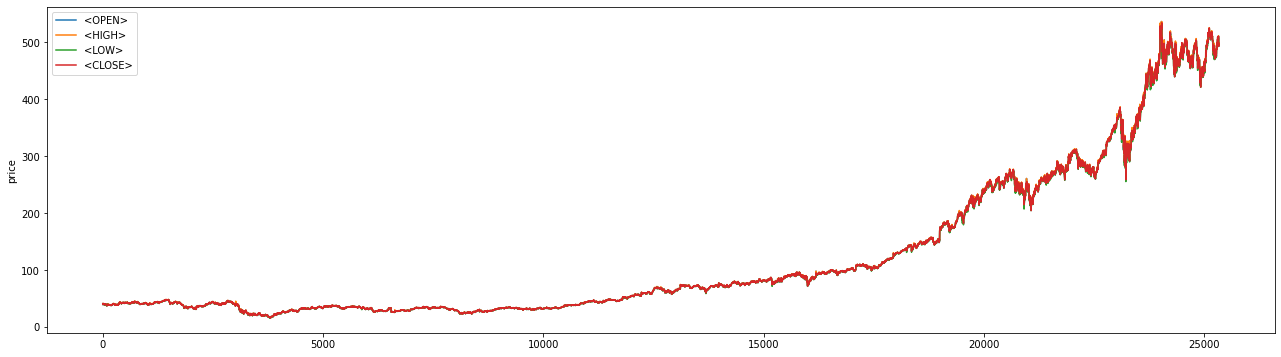

ADBE (25337, 5)


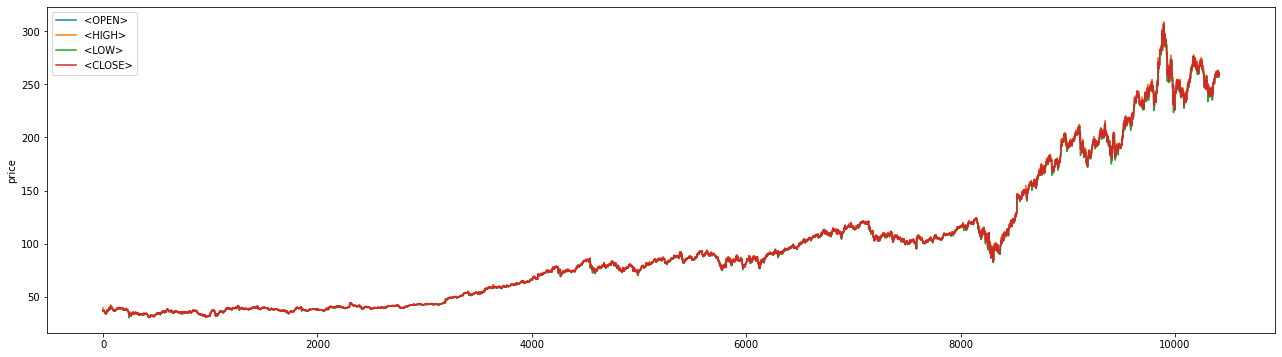

PYPL (10411, 5)


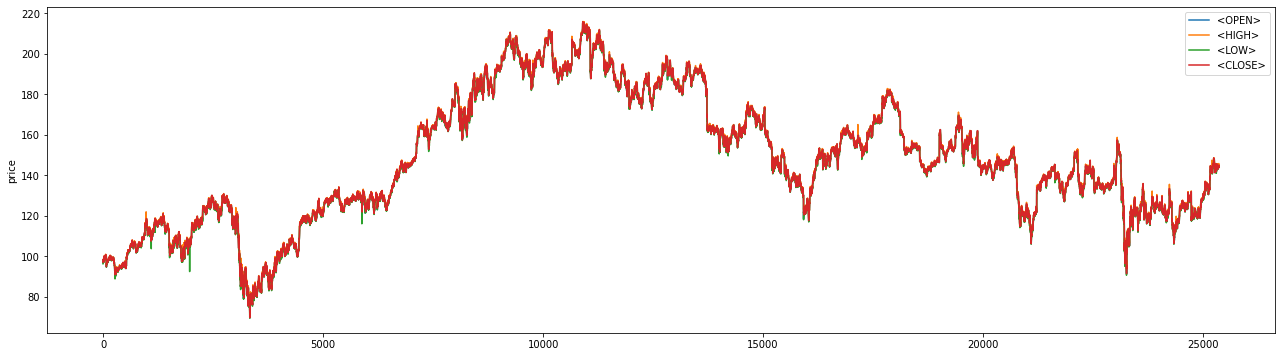

IBM (25361, 5)


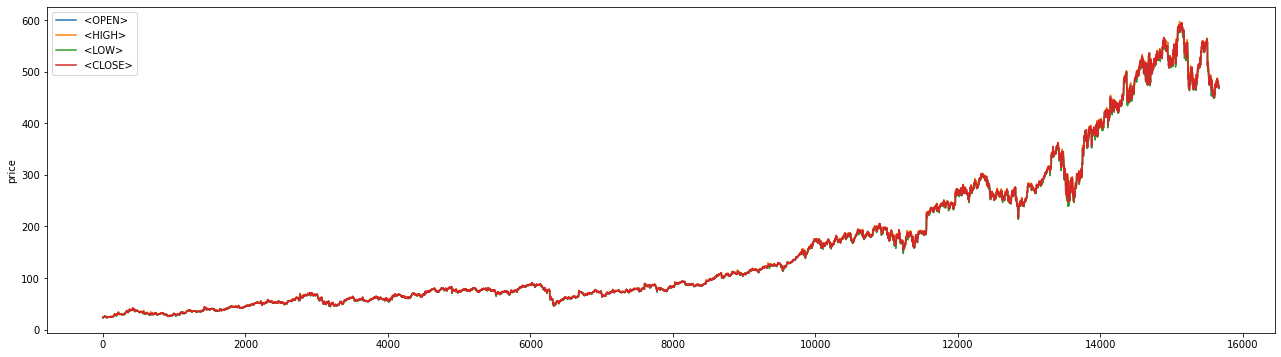

NOW (15664, 5)


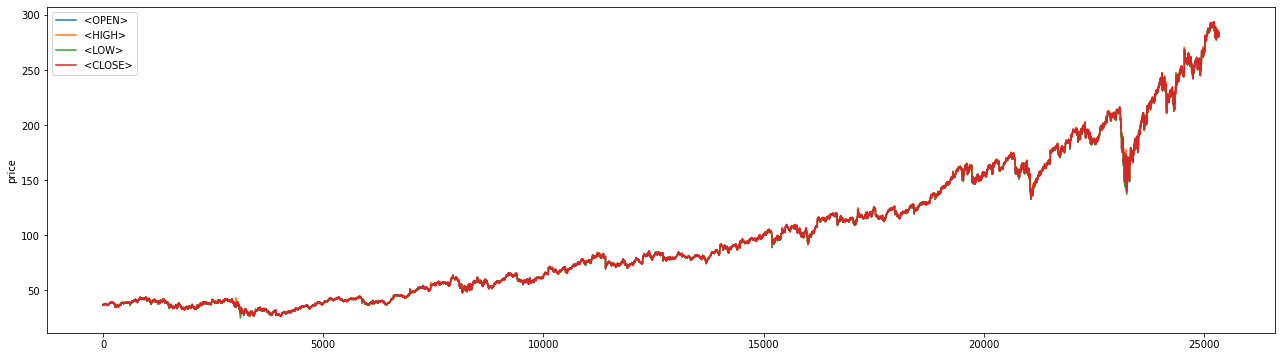

ACN (25336, 5)


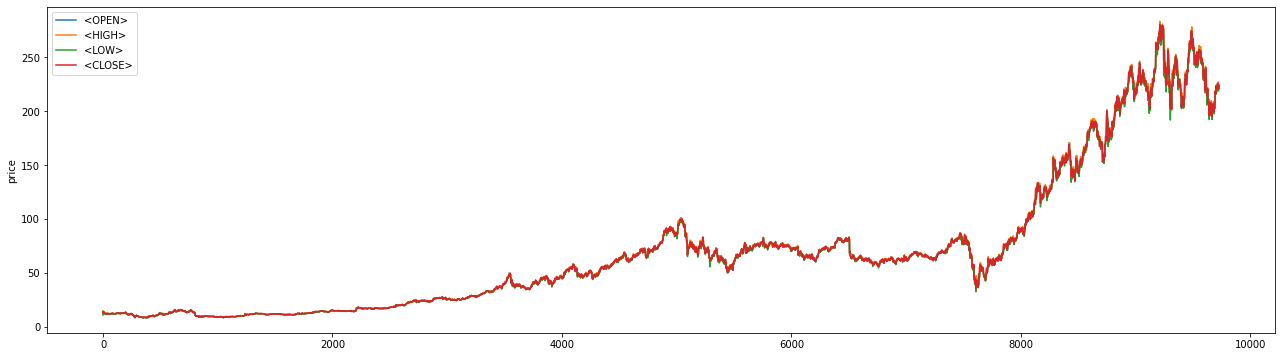

SQ (9727, 5)


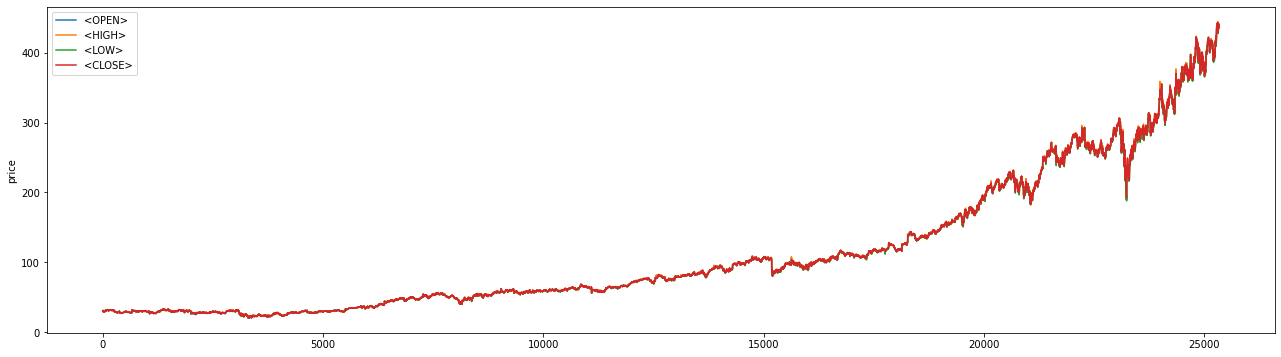

INTU (25337, 5)


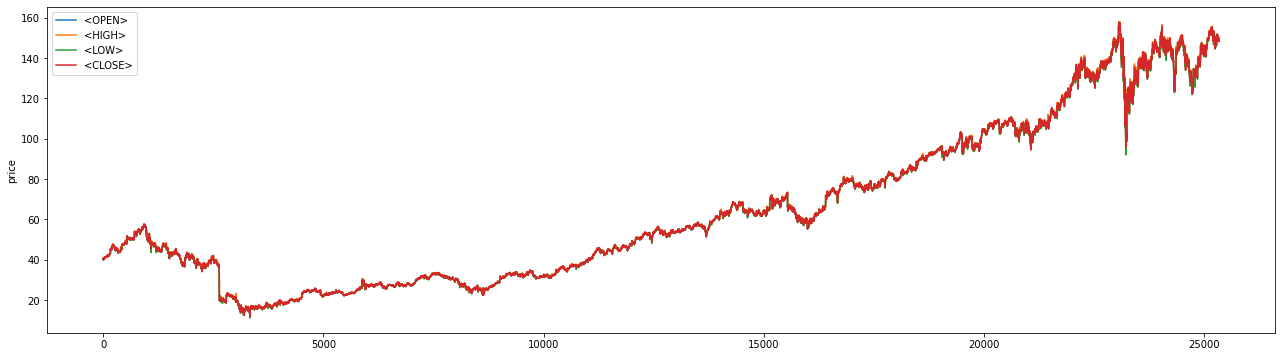

FIS (25335, 5)


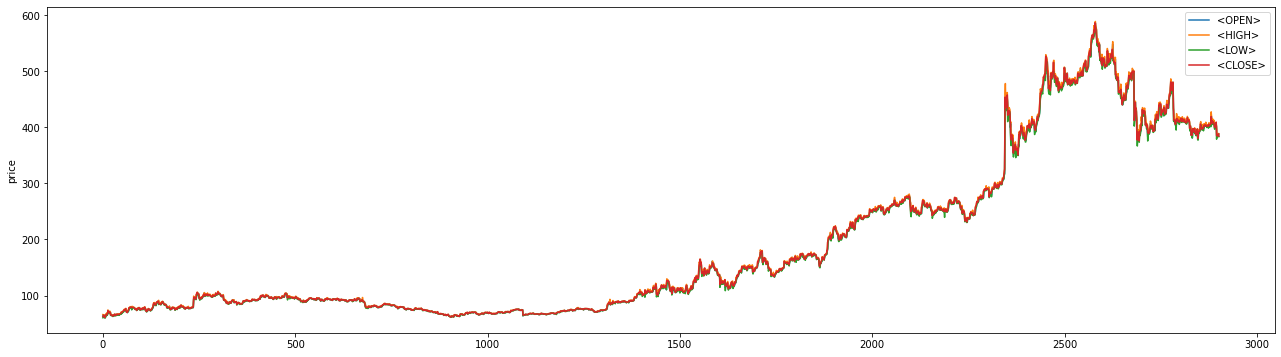

ZM (2902, 5)


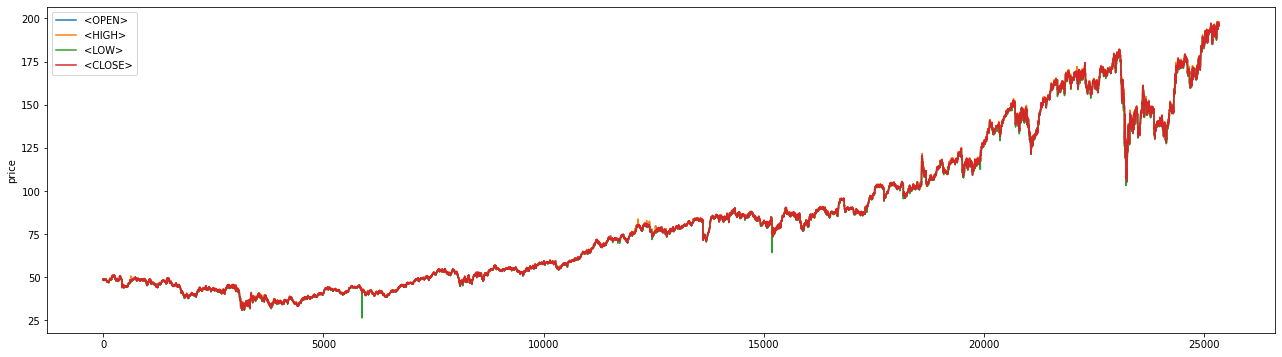

ADP (25336, 5)


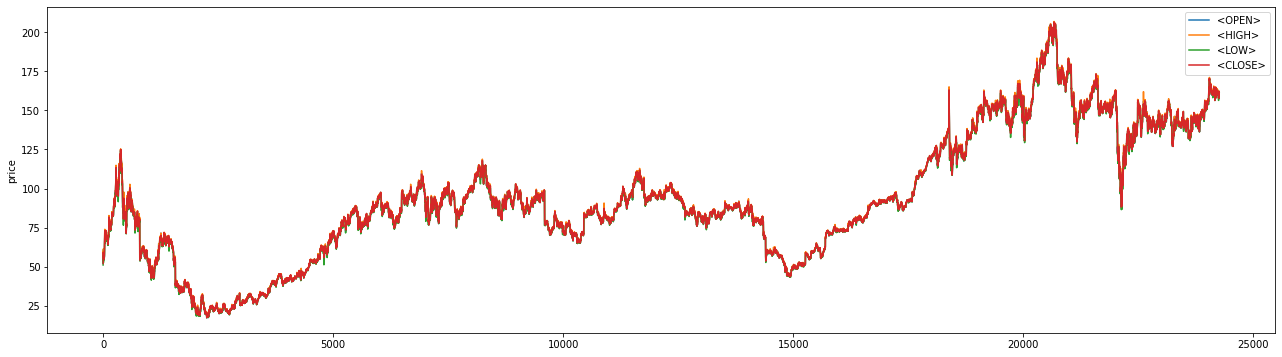

VMW (24256, 5)


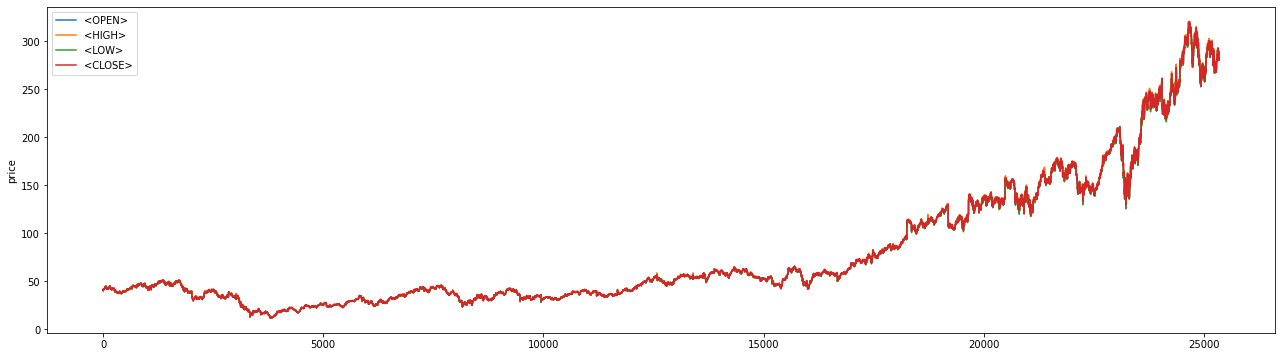

ADSK (25342, 5)


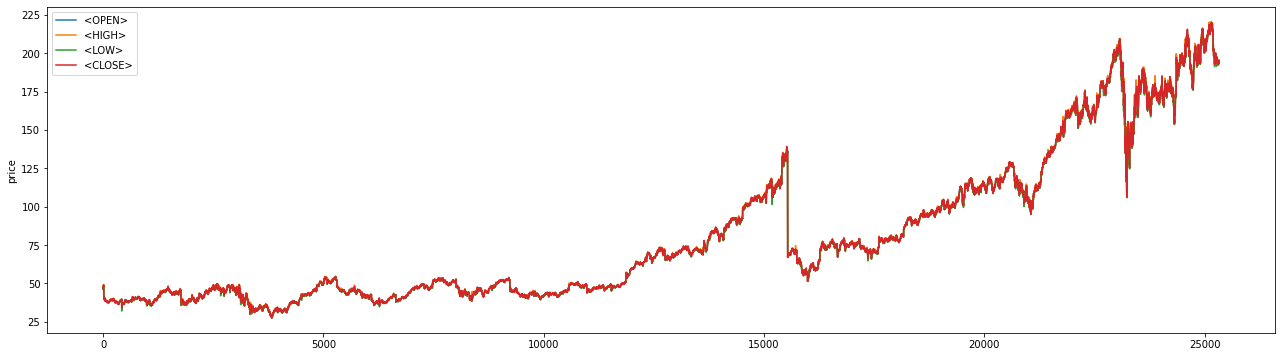

GPN (25328, 5)


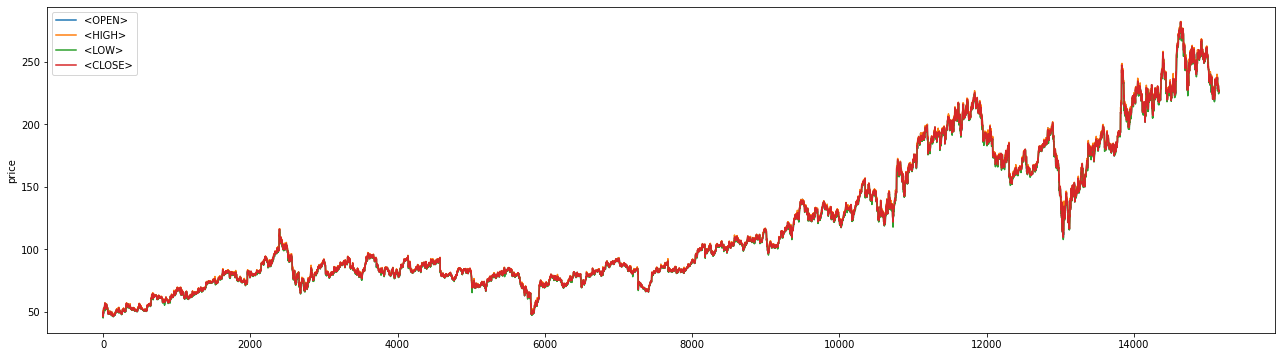

WDAY (15157, 5)


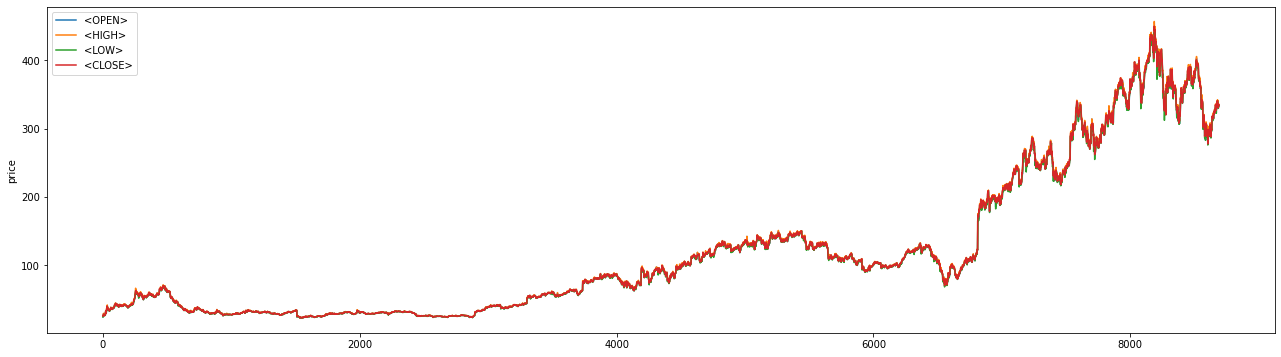

TWLO (8691, 5)


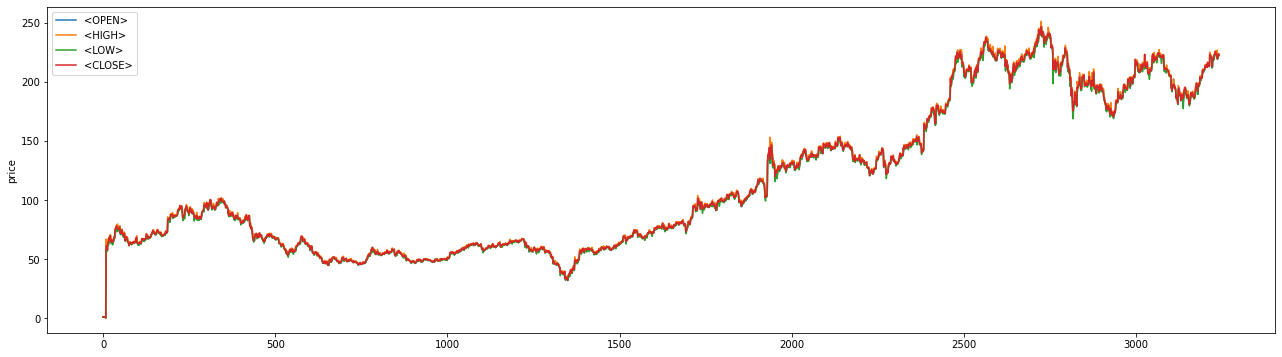

CRWD (3242, 5)
          <OPEN>    <HIGH>     <LOW>   <CLOSE>     <VOL>    Y
0      -0.002006  0.001333 -0.000667  0.003350  10113135  1.0
1       0.003350  0.002662  0.003352  0.004508   6752946  1.0
2       0.004341  0.003983  0.004009  0.003154   5903632  0.0
3       0.003324 -0.001322  0.001664 -0.000659   6269579  0.0
4      -0.000663 -0.000331 -0.023256 -0.022215  11081517  0.0
...          ...       ...       ...       ...       ...  ...
354321 -0.016456 -0.007578 -0.000228  0.004835     11299  1.0
354322  0.004149  0.005015  0.005249  0.009079      3738  1.0
354323  0.009489  0.005575  0.007719  0.004993      5174  0.0
354324  0.004228  0.000492  0.002568 -0.000269      4035  0.0
354325  0.000896 -0.000849 -0.001708 -0.005373     21242  0.0

[354326 rows x 6 columns]
          <OPEN>    <HIGH>     <LOW>   <CLOSE>     <VOL>    Y
0      -0.002006  0.001333 -0.000667  0.003350  10113135  1.0
1       0.003350  0.002662  0.003352  0.004508   6752946  1.0
2       0.004341  0.003983  

In [ ]:
# Extend initial dataset with new tickers
tickers_list = ['CSCO', 'FB', 'ADBE', 'PYPL', 'IBM', 'NOW', 'ACN', 'SQ', 'INTU', 'FIS', 'ZM', 'ADP', 'VMW', 'ADSK', 'GPN', 'WDAY', 'TWLO', 'CRWD']

def extend_initial_dataset(initial_df, initial_df_down, tickers_list):
  for ticker in tickers_list:
    # Get data of stock
    ticker_data = exporter.lookup(market=Market.USA, code=ticker,
                              name_comparator=LookupComparator.CONTAINS)
    assert len(ticker_data) == 1
    df = exporter.download(ticker_data.index[0], market=Market.USA, timeframe=Timeframe.HOURLY)
    df = df.iloc[:,2:]
    df.reset_index(inplace=True, drop=True)

    # Draw the data in channels to check if data is ok
    plt.figure(figsize=(22,6))
    for i in range(4):
      plt.plot(df.iloc[:,i], 
              label=col[i])
    plt.ylabel('price')
    plt.legend()
    plt.show()

    df_up = df.copy()
    df_down = df.copy()

    # Apply target functions
    df_up = target(df_up)
    df_down = target_down(df_down)
    print(ticker, df.shape)
    initial_df = pd.concat([initial_df, df_up])
    initial_df.reset_index(inplace=True, drop=True)
    initial_df_down = pd.concat([initial_df_down, df_down])
    initial_df_down.reset_index(inplace=True, drop=True)
  return initial_df, initial_df_down

data_train, data_train_down = extend_initial_dataset(data_train, data_train_down, tickers_list)
print(data_train)
print(data_train_down)

In [ ]:
# Show the % of Y=1
print(data_train[data_train['Y'] ==1]['Y'].count() / data_train.shape[0] * 100)
print(data_train[data_train['Y'] ==1]['Y'].count())
print(data_train_down[data_train_down['Y'] ==1]['Y'].count() / data_train.shape[0] * 100)
print(data_train_down[data_train_down['Y'] ==1]['Y'].count())

39.12823755935879
138593
43.617201483899024
154493


In [ ]:
# Prepare data
def data_preprocessing(data, train=True):
  '''
  Function for data preprocessing. Calculates pct_change, makes scalling separatelly for price and volumes, saves scalers. 
  Separates dataset xTrain, xTest, yTrain, yTest, yTrain01, yTest01
  return: ndarrays and scaler
  '''
  # Pct_change for price columns
  if not train:
    for c in price_columns:
      data[c]=data[c].pct_change()

  data[volume_column] = data[volume_column] + 1e-5  # Add very small figure to exclude devide by 0
  data[volume_column] = data[volume_column].pct_change()

  data.dropna(axis=0, how='any', inplace=True)

  if not os.path.exists("/content/drive/MyDrive/Colab Notebooks/Dipl/scalers/"):
    os.makedirs("/content/drive/MyDrive/Colab Notebooks/Dipl/scalers/")

  # Create filename for scalers
  price_scaler_filename="/content/drive/MyDrive/Colab Notebooks/Dipl/scalers/price_scaler.save"
  volume_scaler_filename="/content/drive/MyDrive/Colab Notebooks/Dipl/scalers/volume_scaler.save"

  if train:
    data = np.array(data)
    # Split dataset to train and test
    val_len = int(data.shape[0]*0.15)
    test_len = int(data.shape[0]*0.15)
    train_len = data.shape[0] - val_len - test_len
    xTrain, xVal, xTest = data[:train_len,:4], data[train_len + xlen:train_len + xlen + val_len,:4], data[train_len + xlen + val_len + xlen:,:4]
    yTrain01, yVal01, yTest01 = np.reshape(data[:train_len,-1], (-1,1)), np.reshape(data[train_len + xlen:train_len + xlen + val_len,-1], (-1,1)), np.reshape(data[train_len + xlen + val_len + xlen:,-1], (-1,1)) 

    # Make scale
    price_scaler = MinMaxScaler(feature_range=(-1, 1))
    price_scaler.fit(np.reshape(xTrain[:,3], (-1,1)))
    xTrain[:,:4] = price_scaler.transform(xTrain[:,:4])
    xVal[:,:4] = price_scaler.transform(xVal[:,:4])
    xTest[:,:4] = price_scaler.transform(xTest[:,:4])
    # Save scaler
    joblib.dump(price_scaler, price_scaler_filename)
    
    volume_scaler = MinMaxScaler(feature_range=(-1,1))
    # volume_scaler.fit(np.reshape(xTrain[:,4], (-1,1)))
    # xTrain[:,4] = np.reshape(volume_scaler.transform(np.reshape(xTrain[:,4], (-1,1))), (1, -1))
    # xTest[:,4] = np.reshape(volume_scaler.transform(np.reshape(xTest[:,4], (-1,1))), (1,-1))
    joblib.dump(volume_scaler, volume_scaler_filename)
    
    return xTrain, xVal, xTest, yTrain01, yVal01, yTest01, price_scaler, volume_scaler
    
  else:
    data = np.array(data)
    xTest = data[-xlen:,:]
    price_scaler = joblib.load(price_scaler_filename) 
    # volume_scaler = joblib.load(volume_scaler_filename)

    xTest[:,:4] = price_scaler.transform(xTest[:,:4])
    # xTest[:,4] = np.reshape(volume_scaler.transform(np.reshape(xTest[:,4], (-1,1))), (1,-1))
    
    xTest = np.expand_dims(xTest, axis=0)
    return xTest, price_scaler

In [ ]:
# Apply data preprocessing
xTrain, xVal, xTest, yTrain01, yVal01, yTest01, price_scaler, volume_scaler = data_preprocessing(data_train, train = True)
xTrain, xVal, xTest, yTrain01_down, yVal01_down, yTest01_down, price_scaler, volume_scaler = data_preprocessing(data_train_down, train = True)
print(xTrain)
print(yTrain01)
print(yTrain01_down)

[[0.0642133  0.06256927 0.06421867 0.06697966]
 [0.06658065 0.06572541 0.06578902 0.06374559]
 [0.06415208 0.05304584 0.06018315 0.05463032]
 ...
 [0.04248801 0.05702807 0.05851681 0.06540816]
 [0.06485272 0.04844774 0.05989955 0.04318977]
 [0.04337507 0.06518059 0.0309078  0.06487006]]
[[1.]
 [0.]
 [0.]
 ...
 [1.]
 [1.]
 [1.]]
[[1.]
 [1.]
 [1.]
 ...
 [0.]
 [1.]
 [0.]]


In [ ]:
# To check the right scaling/unscaling
print(data.head())
print('with pct change')
print(data_train.head())
print('xtrain')
print(xTrain[:5,:4])
print('inv trans xtrain')
print(price_scaler.inverse_transform(xTrain[:5,:4]))
# print('inv trans ytrain')
# print(price_scaler.inverse_transform(yTrain[:5]))

   <OPEN>  <HIGH>    <LOW>  <CLOSE>     <VOL>
0   29.91   30.01  29.8499  29.8500   7409675
1   29.85   30.05  29.8300  29.9500  10113135
2   29.95   30.13  29.9300  30.0850   6752946
3   30.08   30.25  30.0500  30.1799   5903632
4   30.18   30.21  30.1000  30.1600   6269579
with pct change
     <OPEN>    <HIGH>     <LOW>   <CLOSE>     <VOL>    Y
1  0.003350  0.002662  0.003352  0.004508 -0.332260  1.0
2  0.004341  0.003983  0.004009  0.003154 -0.125769  0.0
3  0.003324 -0.001322  0.001664 -0.000659  0.061987  0.0
4 -0.000663 -0.000331 -0.023256 -0.022215  0.767506  0.0
5 -0.022215 -0.010596  0.002721  0.012886 -0.061990  1.0
xtrain
[[0.0642133  0.06256927 0.06421867 0.06697966]
 [0.06658065 0.06572541 0.06578902 0.06374559]
 [0.06415208 0.05304584 0.06018315 0.05463032]
 [0.05462241 0.05541514 0.00062277 0.00311076]
 [0.00311076 0.03088082 0.06270995 0.08700436]]
inv trans xtrain
[[ 0.00335008  0.00266223  0.00335233  0.00450751]
 [ 0.00434057  0.00398274  0.00400936  0.0031544 ]
 [ 0

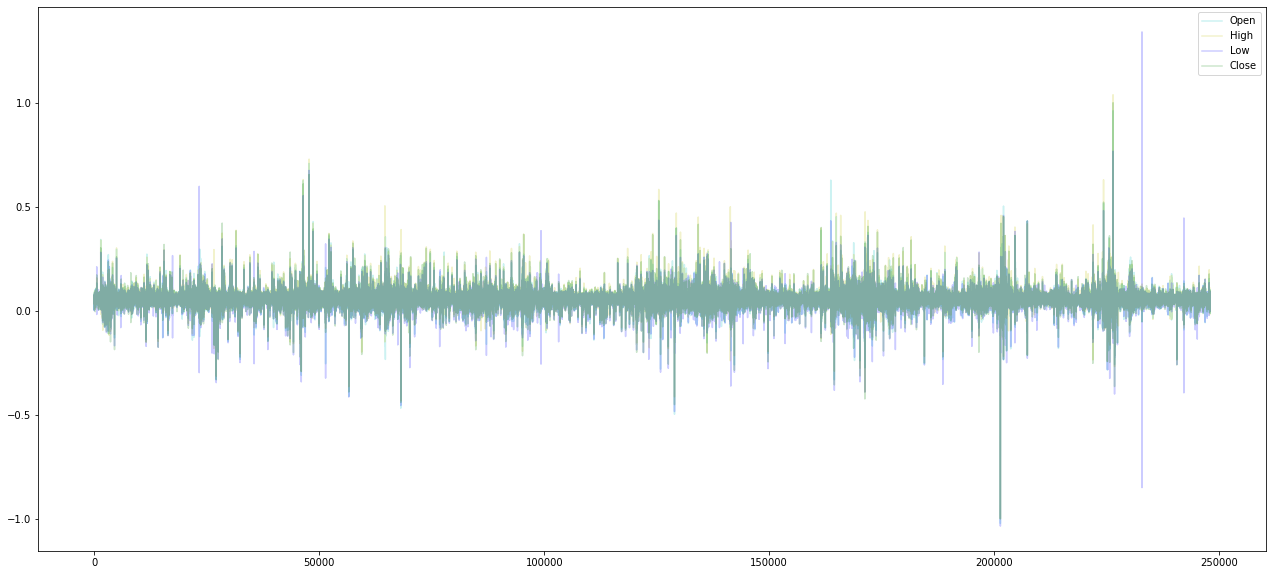

In [ ]:
# Draw scalled dataset to check
plt.figure(figsize=(22,10))
plt.plot(xTrain[:,0], 'c', label='Open', alpha=0.2)
plt.plot(xTrain[:,1], 'y', label='High', alpha=0.2)
plt.plot(xTrain[:,2], 'b', label='Low', alpha=0.2)
plt.plot(xTrain[:,3], 'g', label='Close', alpha=0.2)
# plt.plot(xTrain[:,4], 'r', label='Volume', alpha=0.2)
plt.legend()
plt.show()

In [ ]:
print(yTrain01.shape)
print(yVal01.shape)
print(yTrain01_down.shape)
print(yVal01_down.shape)

(248029, 1)
(53148, 1)
(248029, 1)
(53148, 1)


In [ ]:
# Make time series
train_datagen = TimeseriesGenerator(xTrain, yTrain01, xlen, batch_size=batch_size, shuffle=True)
val_datagen = TimeseriesGenerator(xVal, yVal01, xlen, batch_size=batch_size, shuffle=True)
train_datagen_down = TimeseriesGenerator(xTrain, yTrain01_down, xlen, batch_size=batch_size, shuffle=True)
val_datagen_down = TimeseriesGenerator(xVal, yVal01_down, xlen, batch_size=batch_size, shuffle=True)

In [ ]:
# Make generator for test data for up model
datagen = TimeseriesGenerator(xTest, yTest01,
                               length=xlen, sampling_rate=1,
                               batch_size=len(xTest), shuffle=True) #размер batch будет равен длине нашей выборки
x_test = []
y_test = []
for i in datagen:
  x_test.append(i[0])
  y_test.append(i[1])

x_test = np.array(x_test[0])
y_test = np.array(y_test[0])

print(y_test.shape)
print(y_test[y_test > 0.5].shape)

(52908, 1)
(25342,)


In [ ]:
# Make generator for test data for down model
datagen_down = TimeseriesGenerator(xTest, yTest01_down,
                               length=xlen, sampling_rate=1,
                               batch_size=len(xTest), shuffle=True) #размер batch будет равен длине нашей выборки
x_test_down = []
y_test_down = []
for i in datagen:
  x_test_down.append(i[0])
  y_test_down.append(i[1])

x_test_down = np.array(x_test_down[0])
y_test_down = np.array(y_test_down[0])

print(y_test_down.shape)
print(y_test_down[y_test_down > 0.5].shape)

(52908, 1)
(25313,)


# Содание моделей, подбор параметров и тестирование

In [ ]:
#callback
model_name = f'{file_name}'

reduce_lr = ReduceLROnPlateau(monitor='val_auc', factor=0.5,
                              patience=90, min_lr=0.000001, verbose=1, mode="max" )
early_stop = EarlyStopping(
    monitor='val_auc', min_delta=0, patience=120, verbose=1,
    mode='max', baseline=None, restore_best_weights=True)

checkpoint = ModelCheckpoint(f'/content/drive/MyDrive/Colab Notebooks/Dipl/Models/{model_name}.h5', monitor='val_auc', verbose = 1,
                             save_best_only = True, mode='max')

def on_epoch_end_acc(epoch, logs):
  clear_output(wait=True)
  print('current_val_auc',logs['val_auc'])
  print('current bot_epoch:', it + 1, 'of', bot_epohs)
  print('current bot:', bot_number + 1, 'of', n)
  print('last_bot_accuracy:', val )
  print('last_bot_trade_profit:', trade_profit_list)
  print('last_bot_profit_ratio:', profit_ratio_list)
  print('last_bot_trades:', total_trades_list)

clear = LambdaCallback(on_epoch_end=on_epoch_end_acc)



In [ ]:
# Function for metrics calculation
def f1_loss_calculation(model, x_test, y_test, threshhold=0.6):
  pred = model.predict(x_test)
  pred = np.array([(1 if i>threshhold else 0) for i in pred])
  real = np.array([(1 if i>0.5 else 0) for i in y_test])
  tn, fp, fn, tp = confusion_matrix(real, pred).ravel()
  f1 = round(f1_score(real, pred),3)
  precision = round(tp / (tp + fp), 3)
  recall = round(tp / (tp + fn), 3)
  specificity = round(tn / (tn + fp), 3)
  return f1, precision, specificity, recall, tn, fp, fn, tp


In [ ]:
def plot_history(history):
  plt.plot(history.history['auc'], 
          label='AUC на обучающем наборе')
  plt.plot(history.history['val_auc'], 
          label='AUC на проверочном наборе')
  plt.xlabel('Эпоха обучения')
  plt.ylabel('AUC')
  plt.legend()
  plt.show()

In [ ]:
def check_model(model, x, y_real):
  pred = model.predict(x)
  roc_auc = roc_auc_score(y_real, pred)
  fpr, tpr, thresholds = roc_curve(y_real, pred)
  print()
  plt.plot(fpr, tpr,'r-',label = 'AUC: %.3f'%roc_auc)
  plt.plot([0,1],[0,1],'k-',label='random')
  plt.plot([0,0,1,1],[0,1,1,1],'g-',label='perfect',)
  plt.legend()
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Проверка на тестовой выборке')
  plt.show()

  pred = np.array([(1 if i>0.5 else 0) for i in pred])
  real = np.array([(1 if i>0.5 else 0) for i in y_real])
  print(pred)
  print(real)

  tn, fp, fn, tp = confusion_matrix(real, pred).ravel()
  print('tn:', tn, 'fp:', fp, 'fn:', fn, 'tp:', tp)

  print(classification_report(real, pred))

  cnt_pos=0
  cnt_neg=0
  for i in range(real.shape[0]):
    #print('Predict', pred[i], 'Real',real[i])
    if pred[i] == real[i]:
      cnt_pos +=1
    else:
      cnt_neg+=1

  print()
  print('Positive', cnt_pos, 'Negative',cnt_neg, 'Accuracy {:.2%}'.format(cnt_pos/(cnt_pos+cnt_neg)))
  print()


# Тестовый запуск модели на датасете

In [ ]:
# Function to create model
def create_model():
  inputs = Input(shape=(train_datagen[0][0][0].shape))
  dense = Dense(250, activation='relu')(inputs)
  dense = Dropout(0.2)(dense)
  dense = Flatten()(dense)
  final = Dense(1, activation='sigmoid')(dense)
  model = Model(inputs, final)
  return model


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/1000
485/485 [==============================] - 5s 9ms/step - loss: 0.8577 - auc: 0.6476 - val_loss: 0.6679 - val_auc: 0.6564
Epoch 2/1000
485/485 [==============================] - 4s 8ms/step - loss: 0.6113 - auc: 0.6741 - val_loss: 0.6749 - val_auc: 0.6596
Epoch 3/1000
485/485 [==============================] - 4s 8ms/step - loss: 0.6085 - auc: 0.6826 - val_loss: 0.6815 - val_auc: 0.6573
Epoch 4/1000
485/485 [==============================] - 4s 8ms/step - loss: 0.6089 - auc: 0.6789 - val_loss: 0.6741 - val_auc: 0.6569
Epoch 5/1000
485/485 [==============================] - 4s 8ms/step - loss: 0.6115 - auc: 0.6753 - val_loss: 0.6798 - val_auc: 0.6568
Epoch 6/1000
485/485 [==============================] - 4s 8ms/step - loss: 0.6110 - auc: 0.6774 - val_loss: 0.6653 - val_auc: 0.6586
Epoch 7/1000
485/485 [==============================] - 4s 8ms/step - loss: 0.6157 - auc: 0.6699 - val_loss: 0.6822 - val_auc: 0.6505
Epoch 8/1000
485/485 [==============================] - 4s 8ms

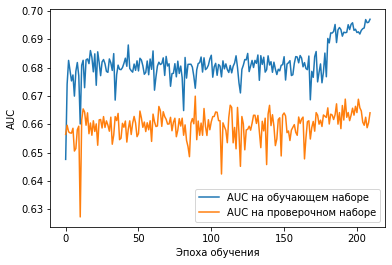

In [ ]:
# Model for up move
model_name = f'{file_name}'
model = create_model()
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=1e-2),  metrics=[AUC(name="auc")])

#Запускаем обучение
history = model.fit(train_datagen, 
                    epochs=1000,
                    verbose=1, 
                    validation_data=val_datagen,
                    callbacks=[reduce_lr, early_stop],
                    )

plot_history(history)

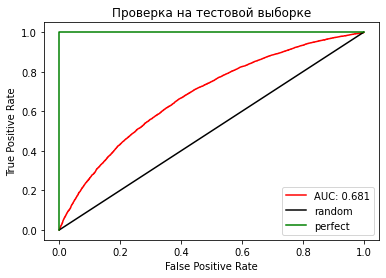

[1 0 1 ... 0 0 1]
[0 0 0 ... 1 1 1]
tn: 19654 fp: 7912 fn: 11528 tp: 13814
              precision    recall  f1-score   support

           0       0.63      0.71      0.67     27566
           1       0.64      0.55      0.59     25342

    accuracy                           0.63     52908
   macro avg       0.63      0.63      0.63     52908
weighted avg       0.63      0.63      0.63     52908


Positive 33468 Negative 19440 Accuracy 63.26%



In [ ]:
check_model(model, x_test, y_test)

Epoch 1/1000
485/485 [==============================] - 5s 9ms/step - loss: 0.6678 - auc: 0.5886 - val_loss: 0.6883 - val_auc: 0.5937
Epoch 2/1000
485/485 [==============================] - 4s 8ms/step - loss: 0.6614 - auc: 0.6097 - val_loss: 0.6852 - val_auc: 0.5954
Epoch 3/1000
485/485 [==============================] - 4s 8ms/step - loss: 0.6606 - auc: 0.6157 - val_loss: 0.6812 - val_auc: 0.6003
Epoch 4/1000
485/485 [==============================] - 4s 8ms/step - loss: 0.6583 - auc: 0.6214 - val_loss: 0.6811 - val_auc: 0.5990
Epoch 5/1000
485/485 [==============================] - 4s 8ms/step - loss: 0.6586 - auc: 0.6189 - val_loss: 0.6983 - val_auc: 0.5908
Epoch 6/1000
485/485 [==============================] - 4s 8ms/step - loss: 0.6564 - auc: 0.6243 - val_loss: 0.6824 - val_auc: 0.5999
Epoch 7/1000
485/485 [==============================] - 4s 8ms/step - loss: 0.6572 - auc: 0.6235 - val_loss: 0.6806 - val_auc: 0.6011
Epoch 8/1000
485/485 [==============================] - 4s 8ms

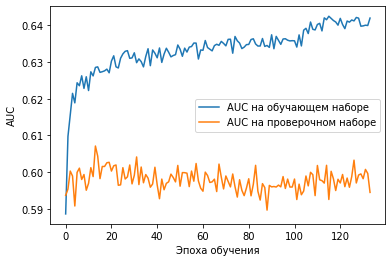

In [ ]:
# Model for down move
model_name_down = f'{file_name}_down'
model_down = create_model()
model_down.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=1e-2),  metrics=[AUC(name="auc")])

#Запускаем обучение
history = model_down.fit(train_datagen_down, 
                    epochs=1000,
                    verbose=1, 
                    validation_data=val_datagen_down,
                    callbacks=[reduce_lr, early_stop],
                    )

plot_history(history)

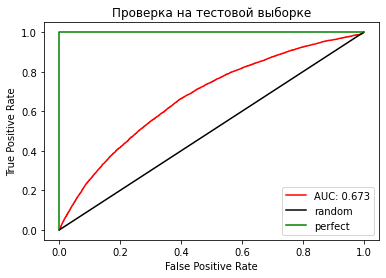

[1 0 0 ... 0 0 0]
[1 0 1 ... 0 1 0]
tn: 21968 fp: 5627 fn: 14602 tp: 10711
              precision    recall  f1-score   support

           0       0.60      0.80      0.68     27595
           1       0.66      0.42      0.51     25313

    accuracy                           0.62     52908
   macro avg       0.63      0.61      0.60     52908
weighted avg       0.63      0.62      0.60     52908


Positive 32679 Negative 20229 Accuracy 61.77%



In [ ]:
check_model(model_down, x_test_down, y_test_down)

In [ ]:
def predTimeseriesGenerator(xTest, step_in_the_past):
  '''
  Функция для преобразования размера входного массива в требуемый для нейросети.
  '''
  xTest = xTest[-step_in_the_past:,:,:4] #формируем х длинной step_in_the_past 
  xTest = np.array(xTest) #Преобразуем в numpy
  
  return xTest

#Функция прогноза
def get_prediction (model, model_down, xPred, yScaler, classification=False):
  '''
  Функция для прогноза данных модели регрессии.
  Если classification=True, возвращает номер класса
  По умолчанию возвращает предсказанное значение
  model - модель
  xPred - входной массив данных
  yScaler - скалер для y
  classification - флаг классификации
  '''
  prediction = model.predict(xPred)  # Get prediction by model
  prediction_down = model_down.predict(xPred)
  if classification:  # If classification
    return prediction, prediction_down  # Return probability of 1
  else:
    prediction = yScaler.inverse_transform(prediction)
    return prediction  # Return predicted figure

def trade(data_enter, model, model_down, step_in_the_past):
  '''
  Функция подготовки входных данных, прогноза цены и определения торгового решения
  '''
  data = data_enter.copy(deep=True)  # Копируем входной датасет, чтобы в нем не было изменений 
  xTest, yScaler = data_preprocessing(data, train=False)  # Делаем предобработку данных в массиве функцией data_preprocessing
  xTest = predTimeseriesGenerator(xTest, step_in_the_past) #формируем вектор со взглядом назад для подачи в сеть
  yPred, yPred_down = get_prediction(model, model_down, xTest, yScaler, classification=True) #делаем прогноз следующей цены закрытия

  yPred = yPred[0][0]
  yPred_down = yPred_down[0][0]

  if yPred >= yPred_down:
    action = 1
  elif yPred < yPred_down:
    action = 2
  else:
    action = 0
  #action = np.random.choice(a=[1,0], size=1, p=[yPred, 1-yPred])

  return action, yPred

def test_model(model, model_down):
  '''
  Function to test model by trading on Test dataset
  return: trade_accuracy, profit_ratio
  '''
  initial_money = 100000 # Стартовый капитал
  money = initial_money 
  shares = 0 # Стартовое количество акций
  dataset = data_train_initial  # Get initial test dataset
  money_history = [money] # Статистика капитала

  last_prediction=[0]
  pos=0  # Current position
  enter_price = 0  
  exit_price = 0
  profit_history=[]
  negative_trades = []
  positive_trades = []
  ticker = 3  # Берем цену из колонки "Close"
  buy_hold_enter = 0
  buy_hold_exit = 0
  buy_hold_result = 0
  buy_hold_shares = 0

  # Проходим по всему тестовому датасету
  for i in tqdm(range(1, data_test.shape[0]+1), position=0):
    df = dataset.append(data_test[:i]).reset_index(drop=True) # Считываем очередное значение из тестового датасета и добавляем в основной датасет
    if i == 1:
      buy_hold_enter = df.iloc[-1][ticker]
      buy_hold_shares += money // df.iloc[-1][ticker]

    action, probability = trade(df, model, model_down, xlen) # Получаем действие, которое будем совершать
    
    # Если это последнее значение тестовой выборки, не торгуем
    if i == data_test.shape[0]:
      buy_hold_exit = df.iloc[-1][ticker]
      buy_hold_result = (buy_hold_exit - buy_hold_enter) * buy_hold_shares

      action = 0  
      if shares != 0:
        money += shares * df.iloc[-1][ticker] # Продаем все акции и увеличиваем капитал на заработанные деньги
        shares = 0 # Количество акцией сбрасываем в 0

    # Если должны покупать и есть деньги хотя бы на одну акцию
    if action == 1 and money > df.iloc[-1][ticker] and shares == 0:
      last_price = df.iloc[-1][ticker]
      shares += money // df.iloc[-1][ticker]  # Покупаем на все имеющиеся деньги акции (покупаем целое количество (не обязательно))
      money = round(money % df.iloc[-1][ticker], 2) # Считаем сколько осталось денег после покупки акций
      enter_price = df.iloc[-1][ticker]

    # Если должны продавать и есть акции и текущая цена ниже входа на 0.5%
    elif action == 2 and shares != 0 : 
      money += round((shares * df.iloc[-1][ticker]), 2) # Продаем все акции и увеличиваем капитал на заработанные деньги
      shares = 0 # Количество акцией сбрасываем в 0
      money_history.append(round(money,2)) # Записываем в статистику капитала текущее значение имеющихся денег
      trade_accuracy = round((money_history[-1] - initial_money), 2)
      exit_price = df.iloc[-1][ticker]
      profit_history.append(exit_price - enter_price)


  positive_trades = [i for i in profit_history if i>0]
  negative_trades = [i for i in profit_history if i<=0]
  total_trades = len(profit_history)
  if total_trades != 0:
    positive_trades_ratio = len(positive_trades) / total_trades
    negative_trades_ratio = len(negative_trades) / total_trades
    if len(positive_trades) == 0:
      max_profit = 0
      mean_profit = 0
    else:
      max_profit = max(positive_trades)
      mean_profit = sum(positive_trades) / len(positive_trades)
    if len(negative_trades) == 0:
      draw_down = 0
      mean_loss = 0
      profit_ratio = 1
    else:
      draw_down = min(negative_trades)
      mean_loss = abs(sum(negative_trades)) / len(negative_trades)
      profit_ratio = round(mean_profit / mean_loss, 2)
    
    print('total_trades', total_trades)
    print('positive_trades_ratio', positive_trades_ratio, 'positive_trades', len(positive_trades))
    print('negative_trades_ratio', negative_trades_ratio, 'negative_trades', len(negative_trades))
    print('draw_down', draw_down)
    print('max_profit', max_profit)
    print('profit_ratio', profit_ratio)
  else:
    draw_down = 0
    profit_ratio = 0
    print('total_trades', 0)
    
  trade_accuracy = round((money_history[-1] - initial_money), 2)
  print('total_return: ', round((money_history[-1] - initial_money), 2))
  print('trade_accuracy', trade_accuracy)

  print('buy_hold_result', buy_hold_result)
  print('buy_hold_result %', buy_hold_result/initial_money * 100)

  plt.plot(money_history)
  plt.show()

  return trade_accuracy, profit_ratio, total_trades  # Возвращаем финальный прирост капитала

100%|██████████| 5077/5077 [08:09<00:00, 10.38it/s]


total_trades 414
positive_trades_ratio 0.6135265700483091 positive_trades 254
negative_trades_ratio 0.3864734299516908 negative_trades 160
draw_down -10.259999999999991
max_profit 13.890000000000015
profit_ratio 1.18
total_return:  251440.89
trade_accuracy 251430.63
buy_hold_result 137094.59
buy_hold_result % 137.09458999999998


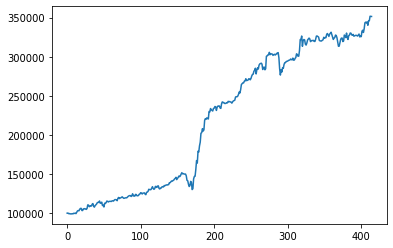

(251430.63, 1.18, 414)

In [ ]:
test_model(model, model_down)

In [ ]:
# model.save(f'/content/drive/MyDrive/Colab Notebooks/Dipl/Models/model_test.h5')
# model_down.save(f'/content/drive/MyDrive/Colab Notebooks/Dipl/Models/model_down_test.h5')

In [ ]:
# Загружаем модели
model = load_model('/content/drive/MyDrive/Colab Notebooks/Dipl/Models/model_test.h5')
model_down = load_model('/content/drive/MyDrive/Colab Notebooks/Dipl/Models/model_down_test.h5')

# Выводы:

1. Обе модели показвают приемлемую разницу tp - fp на рахитектуре с одним dense слоем.

2. Подобраны параметры xlen и batch_size

3. Усложнение архитектуры не дало улучшений в качестве прогнозов моделей

# ПРИЛОЖЕНИЕ:
1. Подбор xlen, batch_size, threashold

2. Подбор архитектуры с помощью ГА

3. Тест сети

# Подбор xlen, batch_size, threashold

In [ ]:
#  Callback for dataset parameters adjustment
def on_epoch_end_data(epoch, logs):
  clear_output(wait=True)
  print('current_val_auc',round(logs['val_auc'],3))
  best_auc.append(round(logs['val_auc'],3))
  print('best_auc', max(best_auc))
  print('current xlen:', xlen_list.index(xlen) + 1, 'of', len(xlen_list))
  print('current batch_size:', batch_size_list.index(batch_size) + 1, 'of', len(batch_size_list))
  
clear_data = LambdaCallback(on_epoch_end=on_epoch_end_data)

def create_model(train_datagen):
  '''
  Function craetes model
  arg: timeseries generator
  return: model
  '''
  inputs = Input(shape=(train_datagen[0][0][0].shape))
  dense = Dense(250, activation='relu')(inputs)
  dense = Dropout(0.2)(dense)
  dense = Flatten()(dense)
  final = Dense(1, activation='sigmoid')(dense)
  model = Model(inputs, final)
  return model

def create_data(xlen, batch_size):
  '''
  Function creates timeseries generators for train, val, test. Creates model.
  args: int, int
  return: model, np.array, np.array 
  '''
  xTrain, xVal, xTest, yTrain01, yVal01, yTest01, price_scaler, volume_scaler = data_preprocessing(data_train, train = True)
  # Make time series
  train_datagen = TimeseriesGenerator(xTrain, yTrain01, xlen, batch_size=batch_size, shuffle=True)
  val_datagen = TimeseriesGenerator(xVal, yVal01, xlen, batch_size=batch_size, shuffle=True)
  datagen = TimeseriesGenerator(xTest, yTest01,
                               length=xlen, sampling_rate=1,
                               batch_size=len(xTest), shuffle=True) #размер batch будет равен длине нашей выборки
  x_test = []
  y_test = []
  for i in datagen:
    x_test.append(i[0])
    y_test.append(i[1])

  x_test = np.array(x_test[0])
  y_test = np.array(y_test[0])

  model = create_model(train_datagen)
  model.compile(loss='binary_crossentropy', optimizer=Adam(lr=1e-2),  metrics=[AUC(name="auc")])
  history = model.fit(train_datagen, 
                      epochs=1000,
                      verbose=1, 
                      validation_data=val_datagen,
                      callbacks=[reduce_lr, early_stop, clear_data],
                      )
  return model, x_test, y_test  # Return model and datasets

In [ ]:
xlen_list = [24, 48, 120, 240, 580]
batch_size_list = [64, 128, 256, 512, 1024, 5000]
threasholds_list = np.linspace(0.1, 0.9, num=9)
best_auc = []
bot_f1 = 0
bot_precision = 0
bot_specificity = 0
bot_recall = 0

test_result = pd.DataFrame(columns=['xlen', 'batch_size', 'threashold', 'f1', 'precision', 'specificity', 'recall', 'tn', 'fp', 'fn', 'tp'])
# Run test
for xlen in xlen_list:
  for batch_size in batch_size_list:
    model, x_test, y_test = create_data(xlen, batch_size)
    for threashold in threasholds_list:
      f1, precision, specificity, recall, tn, fp, fn, tp = f1_loss_calculation(model, x_test, y_test, threashold)
      test_result = test_result.append([{'xlen': xlen, 'batch_size': batch_size, 'threashold': threashold , 'f1': f1, 'precision': precision, 'specificity': specificity, 'recall': recall, 'tn': tn, 'fp': fp, 'fn': fn, 'tp': tp}])
    

current_val_auc 0.668
best_auc 0.73
current xlen: 5 of 5
current batch_size: 6 of 6
Epoch 00205: early stopping


In [ ]:
# Save dataframe
test_result.reset_index(inplace=True)
test_result.drop(['index'], inplace=True, axis=1)
test_name = f'test_result_{file_name}'
test_result.to_csv(f'/content/drive/MyDrive/Colab Notebooks/Dipl/test_results/{test_name}.csv')

xlen batch_size  threashold     f1  ...     tn     fp     fn     tp
0     24         64         0.1  0.560  ...      5  25149      2  15994
1     24         64         0.2  0.573  ...   1525  23629    104  15892
2     24         64         0.3  0.625  ...  12327  12827   2890  13106
3     24         64         0.4  0.582  ...  18118   7036   6552   9444
4     24         64         0.5  0.487  ...  21563   3591   9687   6309
..   ...        ...         ...    ...  ...    ...    ...    ...    ...
265  580       5000         0.5  0.555  ...  18782   5627   7463   8162
266  580       5000         0.6  0.484  ...  21099   3310   9586   6039
267  580       5000         0.7  0.392  ...  22574   1835  11373   4252
268  580       5000         0.8  0.282  ...  23443    966  12905   2720
269  580       5000         0.9  0.174  ...  24036    373  14098   1527

[270 rows x 11 columns]

In [ ]:
# Load test results dataframe 
test_result = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Dipl/test_results/test_result_Trading_NET_v3_1.csv', index_col=0)
test_result

xlen  batch_size  threashold     f1  ...     tn     fp     fn     tp
0      24          64         0.1  0.560  ...      5  25149      2  15994
1      24          64         0.2  0.573  ...   1525  23629    104  15892
2      24          64         0.3  0.625  ...  12327  12827   2890  13106
3      24          64         0.4  0.582  ...  18118   7036   6552   9444
4      24          64         0.5  0.487  ...  21563   3591   9687   6309
..    ...         ...         ...    ...  ...    ...    ...    ...    ...
265   580        5000         0.5  0.555  ...  18782   5627   7463   8162
266   580        5000         0.6  0.484  ...  21099   3310   9586   6039
267   580        5000         0.7  0.392  ...  22574   1835  11373   4252
268   580        5000         0.8  0.282  ...  23443    966  12905   2720
269   580        5000         0.9  0.174  ...  24036    373  14098   1527

[270 rows x 11 columns]

In [ ]:
sns.set_style("whitegrid")

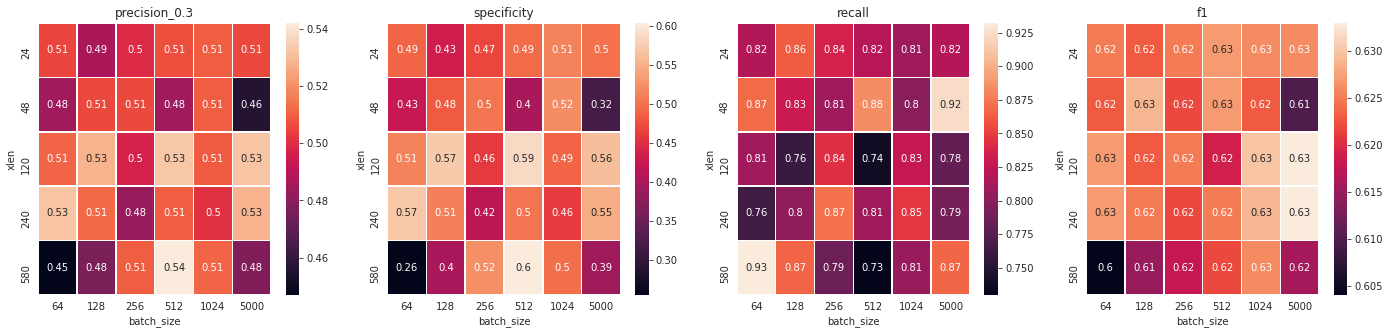

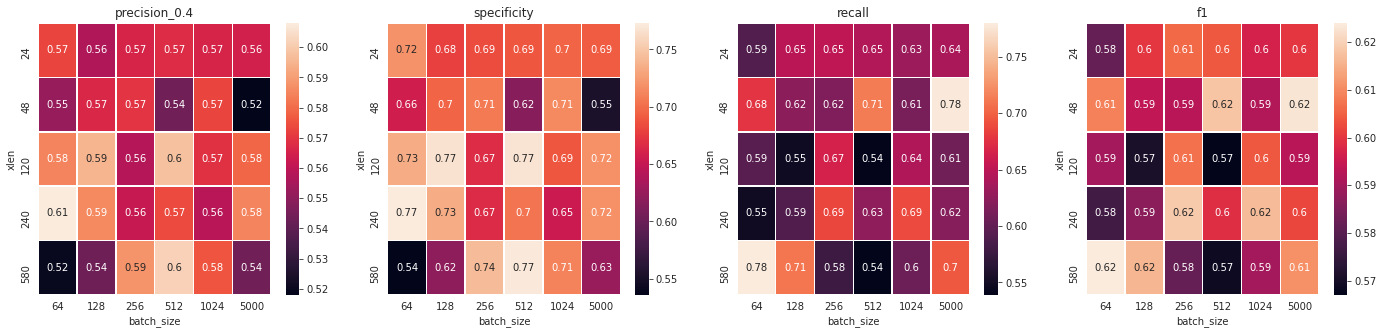

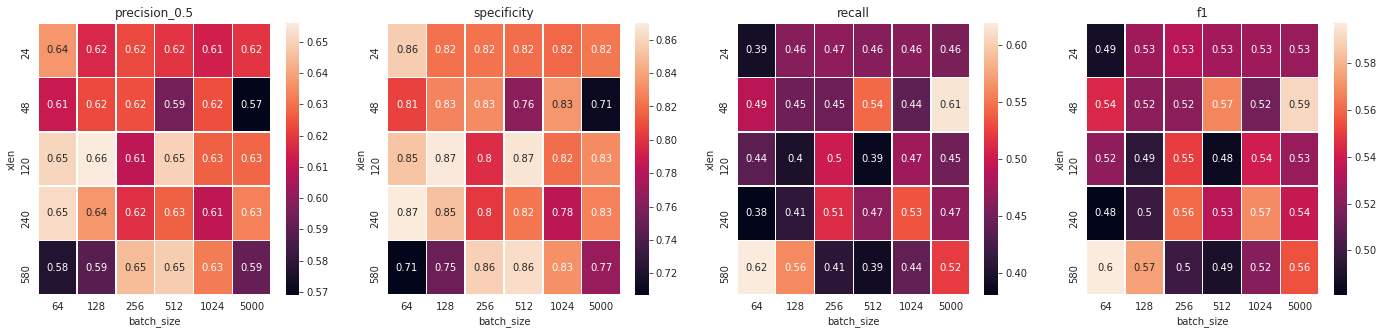

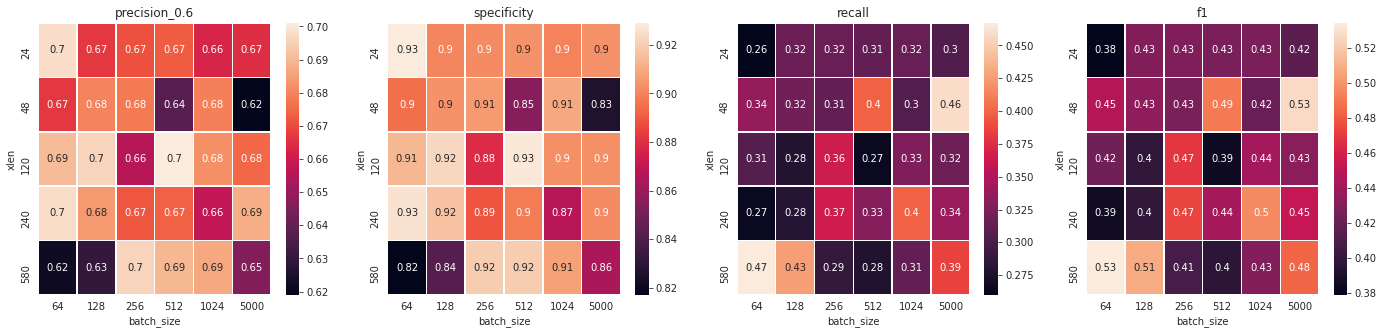

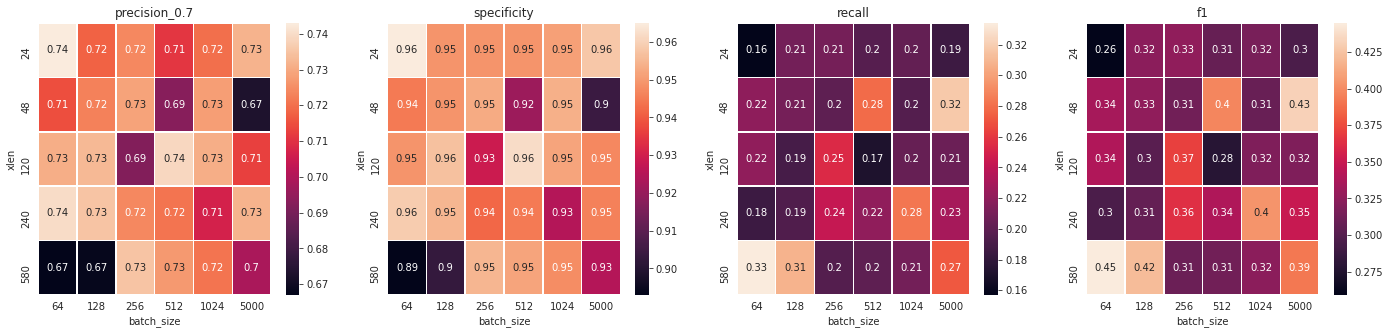

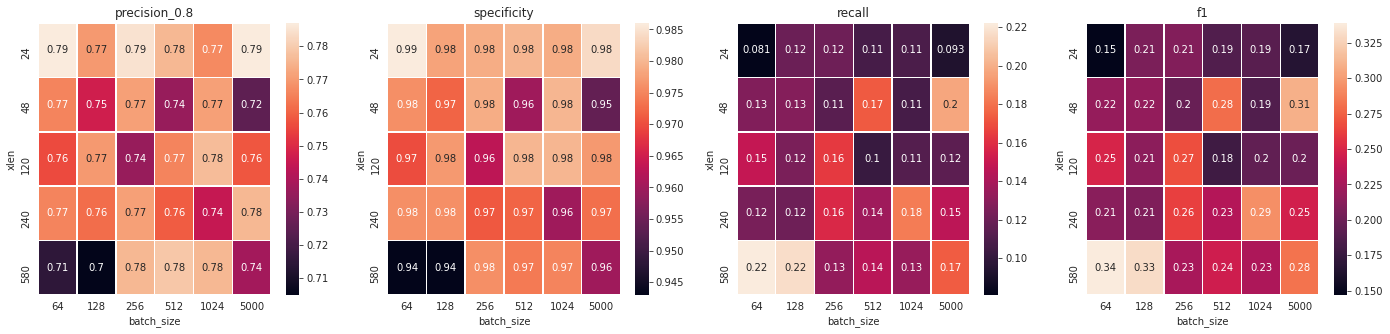

In [ ]:
 for threashold in test_result['threashold'].unique()[2:8]:
  
  test_pivot_precision = test_result[test_result['threashold']==threashold].pivot_table(values='precision', index='xlen', columns='batch_size',)
  test_pivot_specificity = test_result[test_result['threashold']==threashold].pivot_table(values='specificity', index='xlen', columns='batch_size')
  test_pivot_recall = test_result[test_result['threashold']==threashold].pivot_table(values='recall', index='xlen', columns='batch_size')
  test_pivot_f1 = test_result[test_result['threashold']==threashold].pivot_table(values='f1', index='xlen', columns='batch_size')


  fig, sub = plt.subplots(1, 4, figsize=(24, 5))
  sns.heatmap(test_pivot_precision, annot=True, linewidths=.5, ax=sub[0])
  sub[0].set_title(f"precision_{round(threashold,1)}")
  sns.heatmap(test_pivot_specificity, annot=True, linewidths=.5, ax=sub[1])
  sub[1].set_title("specificity")
  sns.heatmap(test_pivot_recall, annot=True, linewidths=.5, ax=sub[2])
  sub[2].set_title("recall")
  sns.heatmap(test_pivot_f1, annot=True, linewidths=.5, ax=sub[3])
  sub[3].set_title("f1")



In [ ]:
test_result['tp-fp'] = (test_result['tp'] - test_result['fp'])

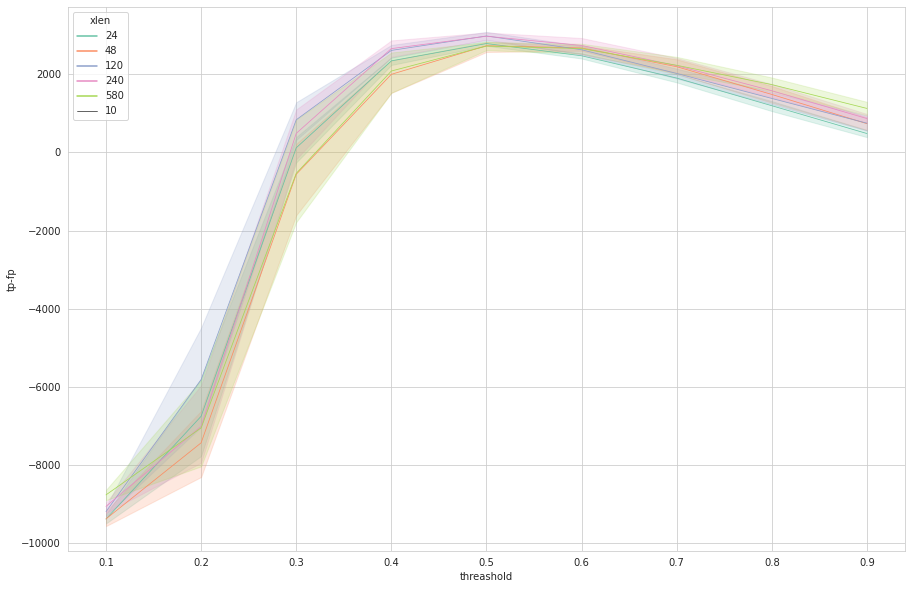

In [ ]:
f, ax = plt.subplots(figsize=(15, 10))
sns.lineplot(data=test_result, x='threashold', y='tp-fp', hue='xlen', size=10, ax=ax, palette="Set2")

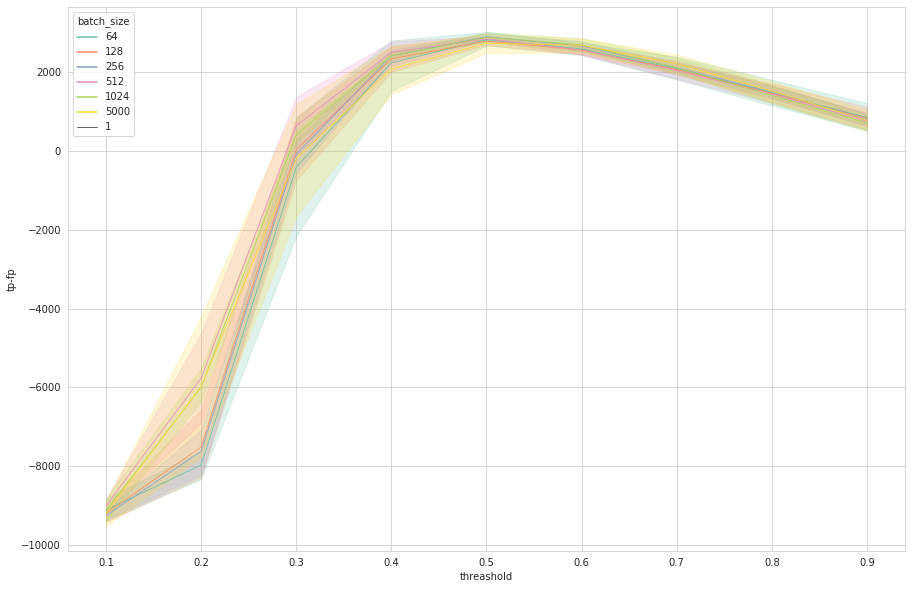

In [ ]:
f, ax = plt.subplots(figsize=(15, 10))
sns.lineplot(data=test_result, x='threashold', y='tp-fp', hue='batch_size', size=1, ax=ax, palette="Set2")

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:1152: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(UserWarning(msg))


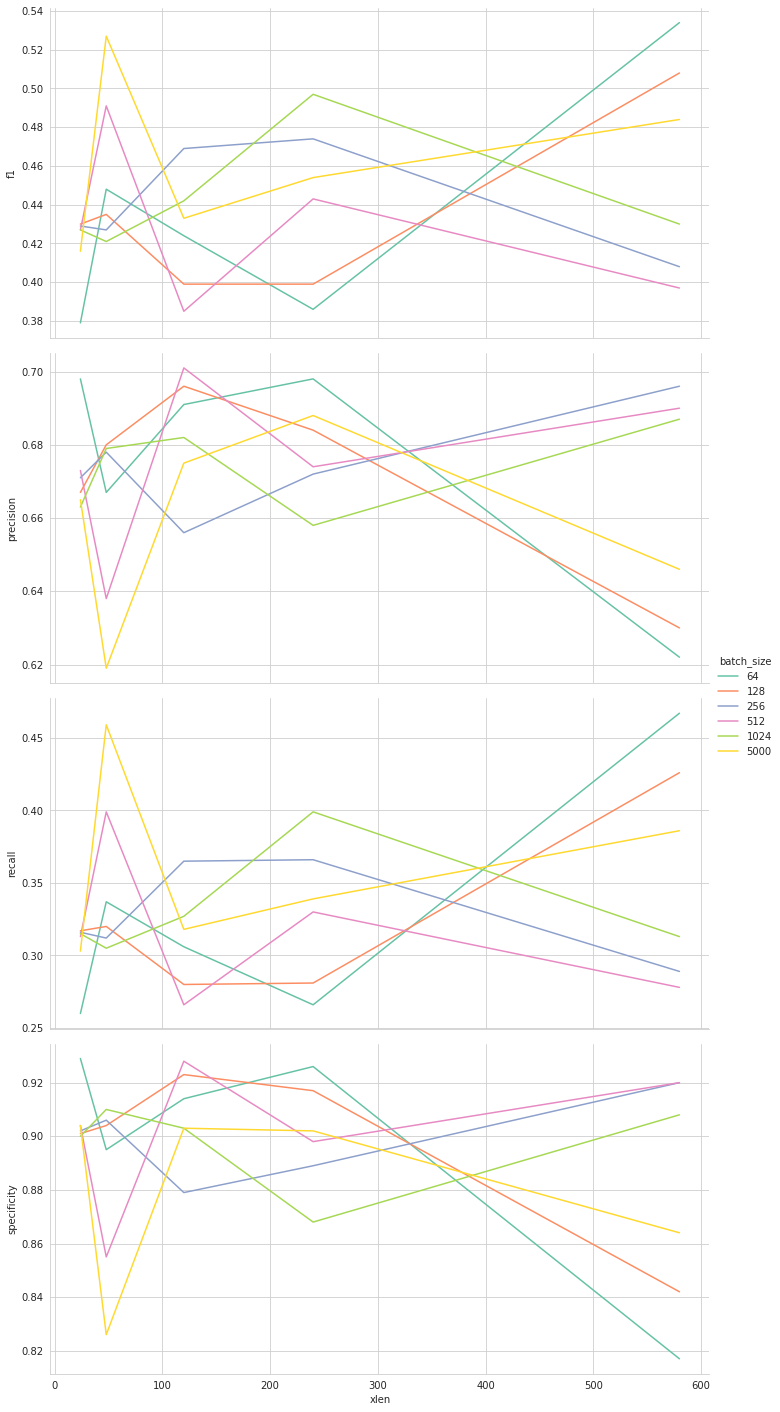

In [ ]:
g = sns.PairGrid(test_result[test_result['threashold']==0.6], x_vars=['xlen'], y_vars=['f1','precision', 'recall', 'specificity'], hue='batch_size', size=5, palette="Set2", aspect=2, )
g.map(sns.lineplot)
g.add_legend()

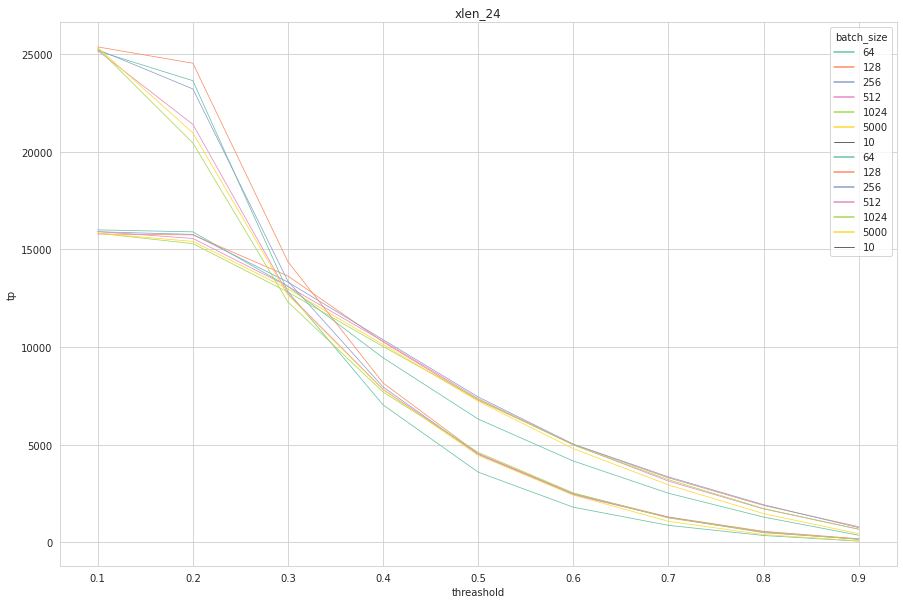

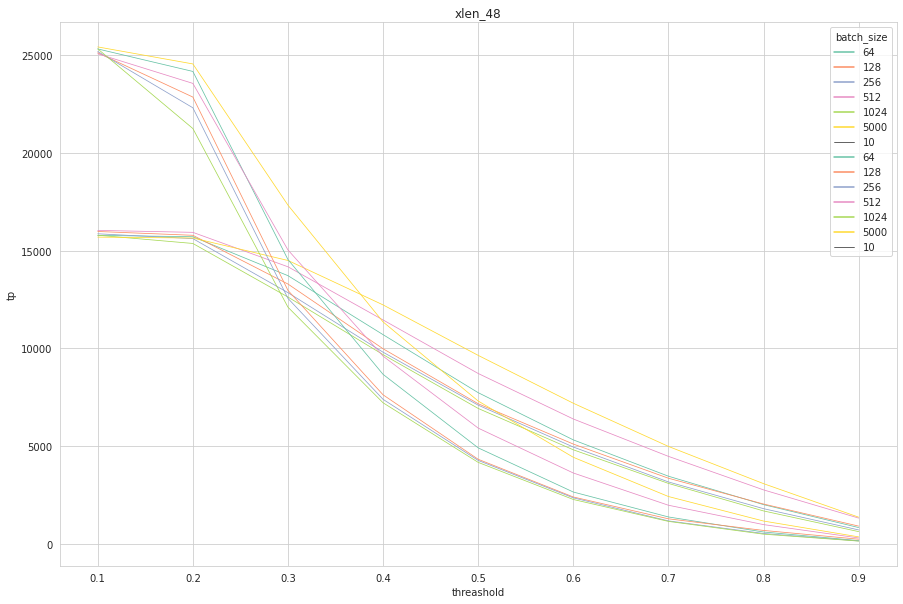

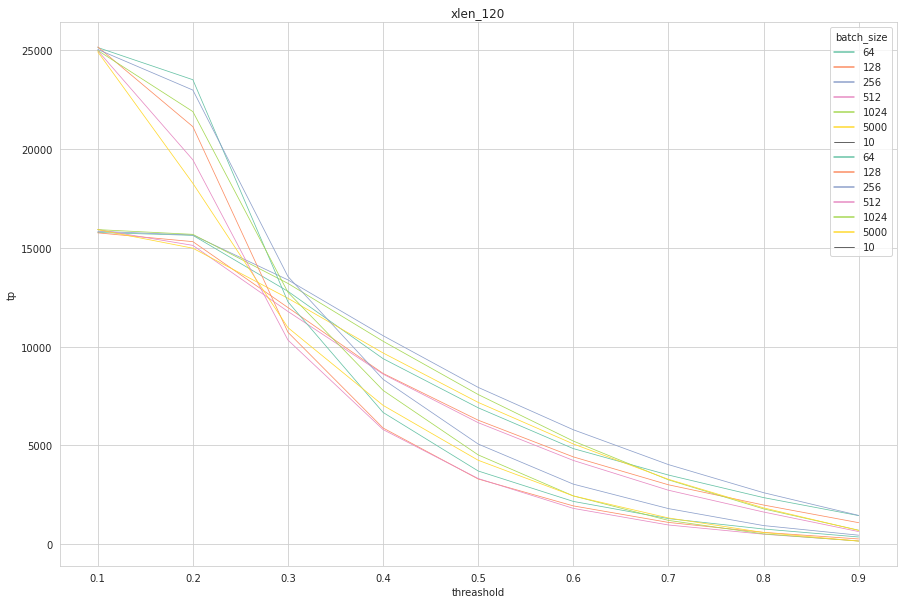

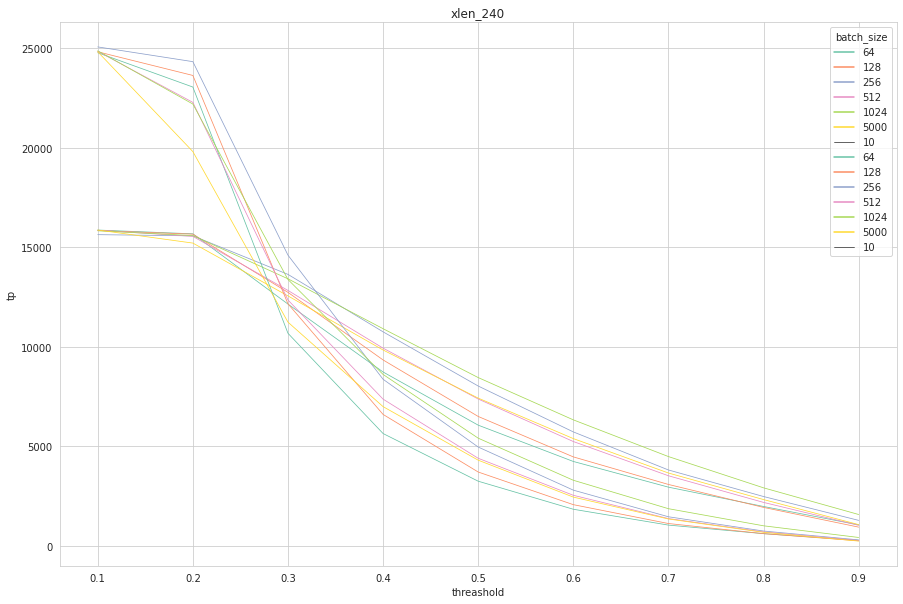

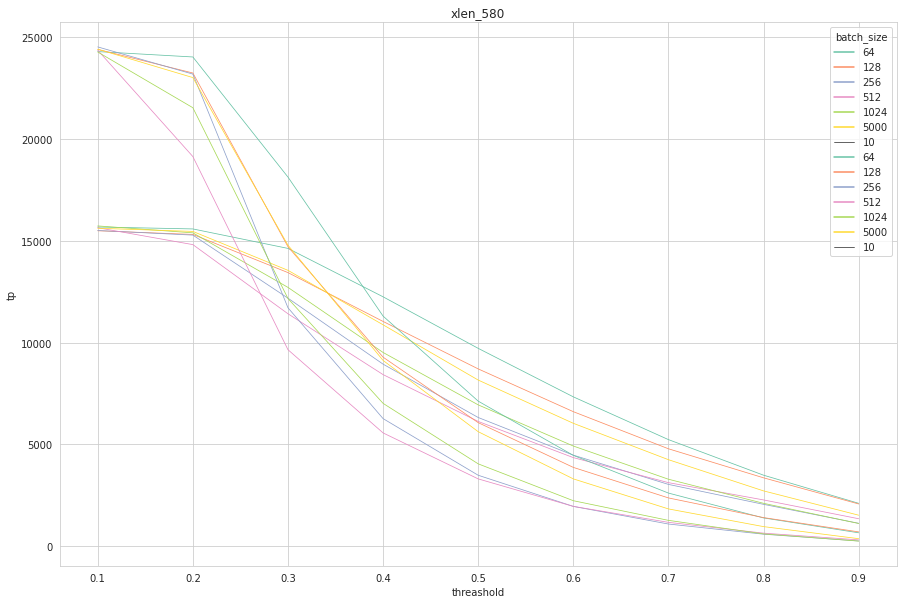

In [ ]:
for xlen in test_result['xlen'].unique():
  f, ax = plt.subplots(figsize=(15, 10))
  sns.lineplot(data=test_result[test_result['xlen']==xlen], x='threashold', y='tp', hue='batch_size', size=10, ax=ax, palette="Set2")
  sns.lineplot(data=test_result[test_result['xlen']==xlen], x='threashold', y='fp', hue='batch_size', size=10, ax=ax, palette="Set2")
  plt.title(f"xlen_{xlen}")

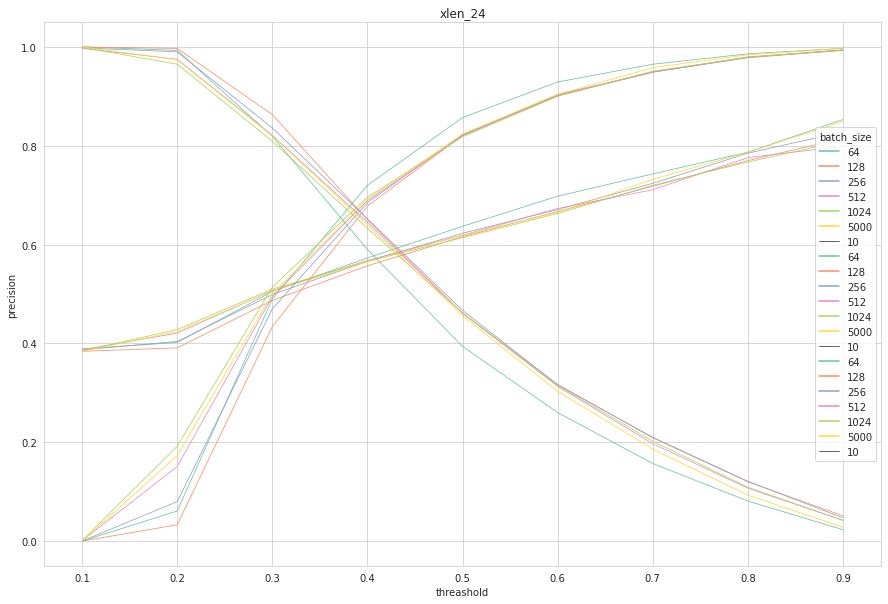

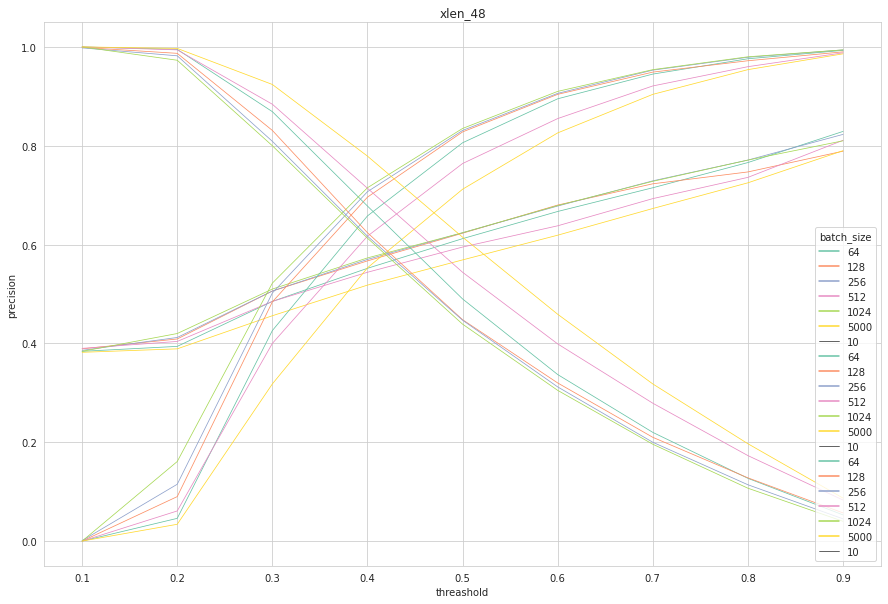

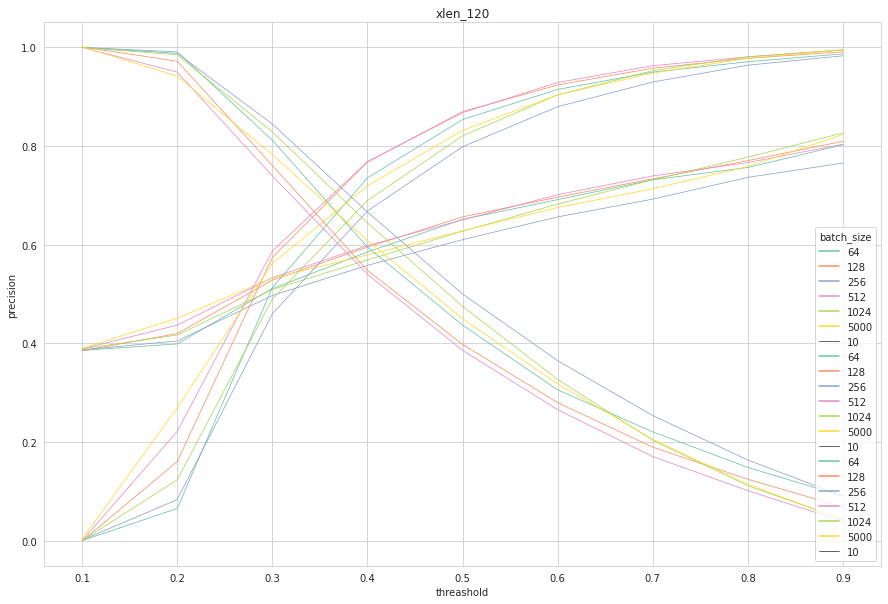

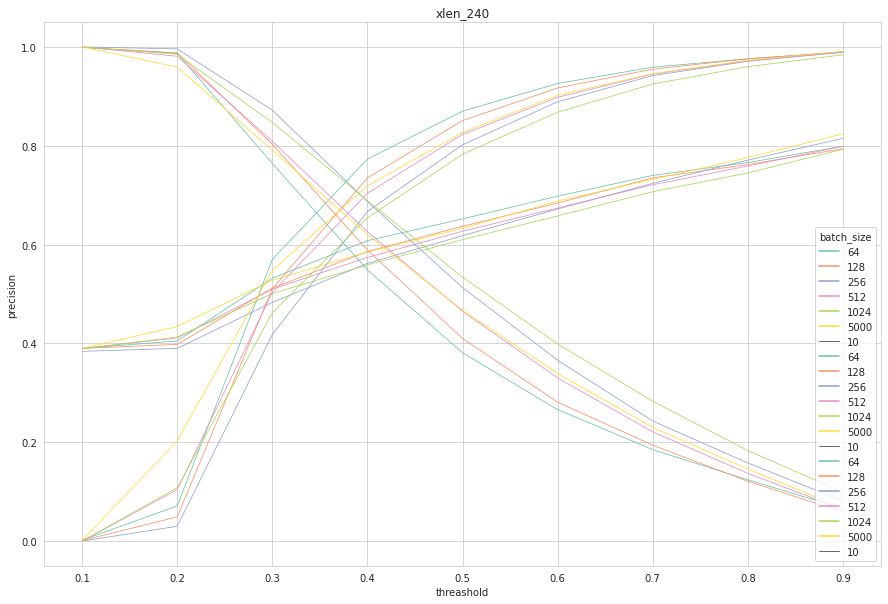

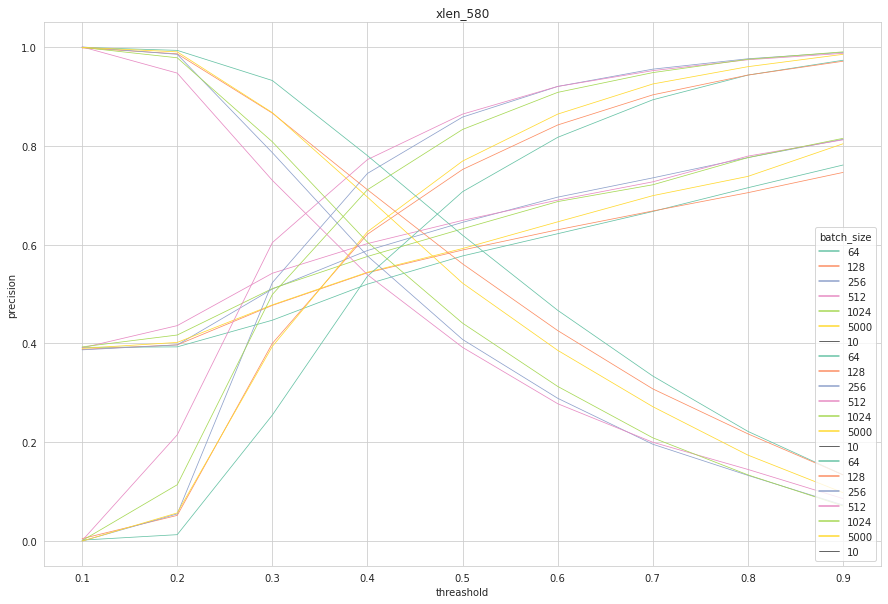

In [ ]:
for xlen in test_result['xlen'].unique():
  f, ax = plt.subplots(figsize=(15, 10))
  sns.lineplot(data=test_result[test_result['xlen']==xlen], x='threashold', hue='batch_size', y='precision', size=10, ax=ax, palette="Set2",)
  sns.lineplot(data=test_result[test_result['xlen']==xlen], x='threashold', hue='batch_size', y='specificity', size=10, ax=ax, palette="Set2", )
  sns.lineplot(data=test_result[test_result['xlen']==xlen], x='threashold', hue='batch_size', y='recall', size=10, ax=ax, palette="Set2",)
  plt.title(f"xlen_{xlen}")


при threashhold 0.4 - 0.6 наилучшая разница tp - fp

при threashold 0.6 - наилучшие precision, specificity

при threashold 0.6 наилучший precision: xlen = 120, batch_size = 512 и xlen = 240, batch_size = 64

С batch_size = 512  скорость обучения сети будет выше, чем с batch_size = 64.

Выбираю параметры входных данных:
xlen = 120, batch_size = 512, threashold 0.6




# Генерируем сеть с помощью ГА с метрикой f1

In [ ]:
def on_epoch_end_f1(epoch, logs):
  clear_output(wait=True)
  print('current_val_auc',logs['val_auc'])
  best_auc.append(round(logs['val_auc'],3))
  print('best_auc', max(best_auc))
  print('current bot_epoch:', it + 1, 'of', bot_epohs)
  print('current bot:', bot_number + 1, 'of', n)
  print('last_val:', val )
  print('last_bot_f1:', bot_f1_list)
  print('last_bot_precision:', bot_precision_list)
  print('last_bot_specificity:', bot_specificity_list)
  print('last_bot_recall:', bot_recall_list)

clear_f1 = LambdaCallback(on_epoch_end=on_epoch_end_f1)

In [ ]:
def create_model_reg(net):
  '''
  Функция создает модель по значениям, полученным из бота
  return: model
  '''
  normalization_on_start = net[0]  # Нормализация перед первым слоем
  dense_on_start_size = 2 ** net[1]    # Размер слоя на старте
  dense_on_start_activation = net[2]    # Активация слоя тна старте
  dense_dropout_on_start = net[3]   # Дропаут на старте
  dropout_on_start_size = net[4]  # Коэффициент Дропаут на старте

  dense_layer = []  # Список для создания Dense слоев
  dense_layer_norm = []  # Список для создания BatchNormalization слоев
  dense_layer_size = []  # Список размеров Dense слоев
  dense_layer_activation = []  # Список активаций Dense слоев
  dense_layer_dropout = []  # Список для создания Dropout слоев
  dense_layer_dropout_size = []  # Список размеров Dropout слоев
  for i in range(max_dense):
    dense_layer.append(net[5 + 6*i])  # Добавляем вкл/выкл для i-го Dense слоя из бота
    dense_layer_norm.append(net[6 + 6*i])  # Добавляем вкл/выкл BatchNormalization для i-го слоя из бота
    dense_layer_size.append(2 ** net[7 + 6*i])  # Добавляем кол-во нейронов для i-го слоя из бота
    dense_layer_activation.append(net[8 + 6*i]) # Активация 
    dense_layer_dropout.append(net[9 + 6*i])  # Dropout
    dense_layer_dropout_size.append(net[10 + 6*i])  # Размер Dropout

  conv_layer = []  # Список для создания слоев
  conv_size = []  # Список размеров слоев
  conv_kernel = []  # Список размеров ядра свертки
  conv_activation = []  # Список активация 
  max_pooling = []  # MaxPooling
  max_pooling_size = []  # MaxPolling size
  for i in range(max_conv):
    conv_layer.append(net[5 + max_dense*6 + 6*i])  # Создаем слой
    conv_size.append(2 ** net[6 + max_dense*6 + 6*i])  # Кол-во нейронов i-го слоя из бота
    conv_kernel.append(net[7 + max_dense*6 + 6*i])  # Размер ядра i-го слоя из бота
    conv_activation.append(net[8 + max_dense*6 + 6*i]) # Активация i-го слоя из бота
    max_pooling.append(net[9 + max_dense*6 + 6*i])  # MaxPolling i-го слоя из бота
    max_pooling_size.append(net[10 + max_dense*6 + 6*i])  # Maxpooling size i-го слоя из бота
  
  lstm_layer = []
  lstm_size = []
  lstm_activation = []
  lstm_return_sequences = []
  for i in range(max_lstm):
    lstm_layer.append(net[5 + max_dense*6 + max_conv*6 + 4*i])
    lstm_size.append(net[6 + max_dense*6 + max_conv*6 + 4*i])
    lstm_activation.append(net[7 + max_dense*6 + max_conv*6 + 4*i])
    lstm_return_sequences.append(net[8 + max_dense*6 + max_conv*6 + 4*i])

  activation_list = ['linear','relu','tanh','softmax','sigmoid']  # Список активаций
  list_to_concat = []  # Список слоев для склейки перед Flatten()

  inputs = Input(shape=(train_datagen[0][0][0].shape))  # Входной слой
  if normalization_on_start:  # Если делаем нормализацию
    dense = BatchNormalization()(inputs) 
    dense = Dense(dense_on_start_size, activation=activation_list[dense_on_start_activation])(dense)
  else:
    dense = Dense(dense_on_start_size, activation=activation_list[dense_on_start_activation])(inputs)

  if dense_dropout_on_start: # Если делаем Dropout
    dense = Dropout(dropout_on_start_size)(dense)

  for i in range(max_dense): # Создаем Dense слои
    if dense_layer[i]:
      if dense_layer_norm[i]:
        dense = BatchNormalization()(dense)
        dense = Dense(dense_layer_size[i], activation=activation_list[dense_layer_activation[i]])(dense)

      else:
        dense = Dense(dense_layer_size[i],activation = activation_list[dense_layer_activation[i]])(dense)
        
      if dense_layer_dropout[i]:
        dense = Dropout(dense_layer_dropout_size[i])(dense)
  
  list_to_concat.append(dense) # Добавляем ветку на соединение

  conv_count = 0
  for i in range(max_conv):  # Создаем Conv слои
    if conv_layer[i]:
      if conv_count == 0:  # Если первый слой, то соединяем с inputs
        conv = Conv1D(conv_size[i], conv_kernel[i], padding = 'same')(inputs)
      else:
        conv = Conv1D(conv_size[i], conv_kernel[i], padding = 'same')(conv)
      conv = Activation(activation_list[conv_activation[i]])(conv)

      # if max_pooling[i]:  # Если делаем MaxPooling
      #   conv = MaxPooling1D(max_pooling_size[i])(conv)
      conv_count +=1
  if conv_count != 0:
    list_to_concat.append(conv)  # Добавляем ветку на соединение

  lstm_count = 0
  for i in range(max_lstm):
    if lstm_layer[i]:
      if lstm_count == 0:
        lstm = LSTM(lstm_size[i], activation=activation_list[lstm_activation[i]])(inputs)
        lstm = Reshape((lstm.shape[1], 1))(lstm)
      else:
        lstm = LSTM(lstm_size[i], activation=activation_list[lstm_activation[i]])(lstm)
        lstm = Reshape((lstm.shape[1], 1))(lstm)
      lstm_count += 1
  if lstm_count != 0:
    list_to_concat.append(lstm)
  
  for i in range(len(list_to_concat)):
    if list_to_concat[i].shape != (None,0,1):  # Если не плоский слой
      list_to_concat[i] = Flatten()(list_to_concat[i])  # Добавляем Flatten
    else:
      break
  
  if len(list_to_concat) != 1:  # Если больше одной ветки в списке
    final = concatenate(list_to_concat)  # Соединяем все ветки
  else:
    final = Flatten()(dense)

  final = Dense(1, activation='sigmoid')(final)

  model = Model(inputs, final)  # Собираем модель
  return model

current_val_auc 0.6744846105575562
best_auc 0.682
current bot_epoch: 10 of 10
current bot: 4 of 4
last_val: [0.457, 0.54, 0.522, 0.573]
last_bot_f1: [0.457, 0.54, 0.522, 0.573]
last_bot_precision: [0.697, 0.667, 0.68, 0.653]
last_bot_specificity: [0.863, 0.791, 0.815, 0.75]
last_bot_recall: [0.34, 0.454, 0.424, 0.51]
Epoch 00162: early stopping
Model: "model_40"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_41 (InputLayer)           [(None, 120, 4)]     0                                            
__________________________________________________________________________________________________
conv1d_126 (Conv1D)             (None, 120, 16)      720         input_41[0][0]                   
__________________________________________________________________________________________________
activation_126 (Activation)     (None, 12

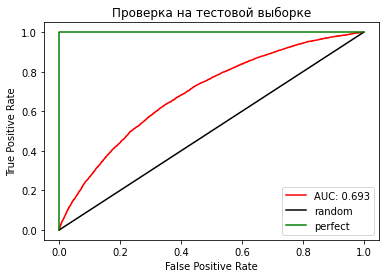

[0 1 1 ... 1 1 0]
[1 1 1 ... 1 0 0]
tn: 22443 fp: 4936 fn: 14808 tp: 10460
              precision    recall  f1-score   support

           0       0.60      0.82      0.69     27379
           1       0.68      0.41      0.51     25268

    accuracy                           0.62     52647
   macro avg       0.64      0.62      0.60     52647
weighted avg       0.64      0.62      0.61     52647


Positive 32903 Negative 19744 Accuracy 62.50%



In [ ]:
def evaluateNet(net, ep, verb):
  '''
  Функция тренирует модель. Делает предсказание по xVal. 
  Получает значение корреляции предсказанного ряда и корреляции базового ряда.
  Считает ошибку как сумму ошибок val_loss + MAE (corr, own_corr).
  input: net, ep, verb
  net - бот
  ep - количесвто эпох
  verb - флаг отоюражения хотда обучения
  Возвращает ошибку и обученную модель.
  return: val, model
  '''
  val = 0
  model = create_model_reg(net)  # Создаем модель create_model_reg
  # Компилируем модель
  model.compile(loss='binary_crossentropy', optimizer=Adam(lr=1e-2),  metrics=[AUC(name="auc")])

  #Запускаем обучение
  history = model.fit(train_datagen, 
                      epochs=ep,
                      verbose=verb, 
                      validation_data=val_datagen,
                      callbacks=[reduce_lr, early_stop, clear_f1],
                      )

  max_auc = max(history.history['val_auc'])

  price_scaler_filename="/content/drive/MyDrive/Colab Notebooks/Dipl/scalers/price_scaler.save"
  price_scaler = joblib.load(price_scaler_filename)  # Загружаем price_scaler

  #bot_f1, bot_precision, bot_specificity, bot_recall, tn, fp, fn, tp  = f1_loss_calculation(model, x_test, y_test)

  return max_auc, model  # Возвращаем точность и модель


def createRandomNet(max_dense, max_conv, max_lstm):
  '''
  Функция создает и возвращает рандомного бота.
  return: net
  '''
  net = []  # Список для хранения значений бота
  net.append(random.randint(0,1)) #0 Нормализацию
  net.append(random.randint(3,8)) #1 Размер слоя 8 до 1024 нейронов
  net.append(random.randint(0,4)) #2 Функция активации слоя
  net.append(random.randint(0,1)) #3 Делаем ли Dropout
  net.append(round(random.uniform(0.1,0.9),1)) #4 Размер Dropout

  for i in range(max_dense):         
    net.append(random.randint(0,1)) # 5 Делаем Dense
    net.append(random.randint(0,1)) # 6 Делаем нормализацию
    net.append(random.randint(3,8)) # 7 Размер слоя 8 до 1024 нейронов
    net.append(random.randint(0,4)) # 8 Активация слоя
    net.append(random.randint(0,1)) # 9 Dropout
    net.append(round(random.uniform(0.1,0.9),1)) # 10 Размер Dropout

  for i in range(max_conv):
    net.append(random.randint(0,1)) #11 Делаем Conv
    net.append(random.randint(3,6)) #12 Размер Conv 8 - 64 нейрона
    net.append(random.randint(3,14)) #13 Ядро свертки
    net.append(random.randint(0,4)) #14 Активация
    net.append(random.randint(0,1)) #15 МаxPooling
    net.append(2)  #16 Размер MaxPooling
  
  for i in range(max_lstm):
    net.append(random.randint(0,1))  #17 Make LSTM
    net.append(random.randint(3,7))  #18 LSTM size
    net.append(random.randint(0,4))  #19 Activation
    net.append(random.choice([False,True]))  #20 Return_sequences
  
  return net

#################################### START OF THE TRAINING #######################
# Initial data for bot
max_conv = 5  #  Maximim number of Conv layers in model
max_dense = 2  # Maximum number of Dense layers in model
max_lstm = 0  # Maximum nuber of LSTM layers in model
n = 4  # Общее число ботов
nsurv = 2  # Количество выживших (столько лучших переходит в новую популяцию)
nnew = n - nsurv  # Количество новых (столько новых ботов создается)
bot_epohs = 10  # количество эпох
train_epochs = 1000
mut = 0.09  # коэфициент мутаций
popul = []  # Массив популяции
val = []  # Одномерный массив значений этих ботов
bot_f1_list = []
bot_precision_list = []
bot_specificity_list = []
bot_recall_list = []
best_auc = []
threasholds_list = np.linspace(0.1, 0.9, num=9)
test_name = f'test_bot_result_{file_name}'
test_bot_result = pd.DataFrame(columns=['bot', 'max_auc', 'threashold', 'f1', 'precision', 'specificity', 'recall', 'tn', 'fp', 'fn', 'tp'])

#Создаём случайных ботов
for i in range(n):
  popul.append(createRandomNet(max_dense, max_conv, max_lstm))

l = len(popul[0])  # Длина бота 
for it in range(bot_epohs):  # Пробегаем по всем эпохам
  val = []  # Обнуляем значения ошибки бота
  bot_f1_list = []
  bot_precision_list = []
  bot_specificity_list = []
  bot_recall_list = []
  curr_time = time.time()
  for i in range(n):  # Пробегаем в цикле по всем ботам
    bot_number = i
    bot = popul[i]  # Берем очередного бота
    max_auc, model = evaluateNet(bot, train_epochs, 1) # Вычисляем точность текущего бота

    for threashold in threasholds_list:
      bot_f1, bot_precision, bot_specificity, bot_recall, tn, fp, fn, tp = f1_loss_calculation(model, x_test, y_test, threashold)
      test_bot_result = test_bot_result.append([{'bot': bot, 'max_auc':max_auc, 'threashold': threashold, 'f1': bot_f1, 'precision': bot_precision, 'specificity': bot_specificity, 'recall': bot_recall, 'tn': tn, 'fp': fp, 'fn': fn, 'tp': tp}])
      test_bot_result.to_csv(f'/content/drive/MyDrive/Colab Notebooks/Dipl/test_results/{test_name}.csv')


    bot_f1, bot_precision, bot_specificity, bot_recall, tn, fp, fn, tp = f1_loss_calculation(model, x_test, y_test)
    val.append(bot_f1) # Добавляем полученное значение в список val
    bot_f1_list.append(bot_f1)
    bot_precision_list.append(bot_precision)
    bot_specificity_list.append(bot_specificity)
    bot_recall_list.append(bot_recall)

  sval = sorted(val, reverse=1) # Сортируем val (если val = ошибка, reverse=0; если val = Результат торговли, reverse = 1)
  # Выводим 5 лучших ботов
  print(it, time.time() - curr_time, " ", sval[0:5],popul[:5]) 
  
  newpopul = []  # Создаем пустой список под новую популяцию
  for i in range(nsurv):  # Пробегаем по всем выжившим ботам
    index = val.index(sval[i])  # Получаем индекс очередного бота из списка лучших в списке val
    newpopul.append(popul[index])  # Добавляем в новую популяцию бота из popul с индексом index
    
  for i in range(nnew):  # Проходимся в цикле nnew-раз  
    indexp1 = random.randint(0,nsurv-1)  # Случайный индекс первого родителя в диапазоне от 0 до nsurv - 1
    indexp2 = random.randint(0,nsurv-1)  # Случайный индекс первого родителя в диапазоне от 0 до nsurv - 1
    botp1 = newpopul[indexp1]  # Получаем первого бота-родителя по indexp1
    botp2 = newpopul[indexp2]  # Получаем второго бота-родителя по indexp2    
    newbot = []  # Создаем пустой список под значения нового бота    
    net4Mut = createRandomNet(max_dense,max_conv, max_lstm)  # Создаем случайную сеть для мутаций
    for j in range(l):  # Пробегаем по всей длине бота      
      x = 0      
      pindex = random.random()  # Получаем случайное число в диапазоне от 0 до 1
      # Если pindex меньше 0.5, то берем значения от первого бота, иначе от второго
      if pindex < 0.5:
        x = botp1[j]
      else:
        x = botp2[j]
      # С вероятностью mut устанавливаем значение бота из net4Mut
      if (random.random() < mut):
        x = net4Mut[j]  
      newbot.append(x)                  # Добавляем очередное значение в нового бота      
    newpopul.append(newbot)             # Добавляем бота в новую популяцию      
  popul = newpopul

test_bot_result.reset_index(inplace=True)
test_bot_result.drop(['index'], inplace=True, axis=1)
test_bot_result.to_csv(f'/content/drive/MyDrive/Colab Notebooks/Dipl/test_results/{test_name}.csv')

print('best bot', popul[0])
model = create_model_reg(popul[0])  # Create model with best bot
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=1e-2),  metrics=[AUC(name="auc")])

#Запускаем обучение
history = model.fit(train_datagen, 
                    epochs=train_epochs,
                    verbose=1, 
                    validation_data=val_datagen,
                    callbacks=[reduce_lr, early_stop, clear_f1],
                    )

model_name = f'{file_name}_f1_selection'  #{time.strftime("%y-%m-%d-%H-%M", time.localtime(time.time()))}'
model.save(f'/content/drive/MyDrive/Colab Notebooks/Dipl/Models/{model_name}.h5')
model.summary()  # Model summary
plot_model(model)  # Plot model
plot_model(model, to_file=f"/content/drive/MyDrive/Colab Notebooks/Dipl/Models/{model_name}.png")

check_model(model, x_test, y_test)

In [ ]:
import pandas as pd

test_bot_result = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Dipl/test_results/test_bot_result_Trading_NET_v3_1.csv', index_col=0)
test_bot_result

bot   max_auc  ...     fn     tp
0    [1, 6, 4, 0, 0.4, 1, 0, 7, 0, 0, 0.3, 0, 0, 7,...  0.667327  ...      7  25261
1    [1, 6, 4, 0, 0.4, 1, 0, 7, 0, 0, 0.3, 0, 0, 7,...  0.667327  ...    916  24352
2    [1, 6, 4, 0, 0.4, 1, 0, 7, 0, 0, 0.3, 0, 0, 7,...  0.667327  ...   4113  21155
3    [1, 6, 4, 0, 0.4, 1, 0, 7, 0, 0, 0.3, 0, 0, 7,...  0.667327  ...   8035  17233
4    [1, 6, 4, 0, 0.4, 1, 0, 7, 0, 0, 0.3, 0, 0, 7,...  0.667327  ...  12064  13204
..                                                 ...       ...  ...    ...    ...
355  [1, 4, 1, 0, 0.7, 0, 0, 7, 1, 1, 0.6, 1, 0, 3,...  0.679898  ...   8499  16769
356  [1, 4, 1, 0, 0.7, 0, 0, 7, 1, 1, 0.6, 1, 0, 3,...  0.679898  ...  12383  12885
357  [1, 4, 1, 0, 0.7, 0, 0, 7, 1, 1, 0.6, 1, 0, 3,...  0.679898  ...  16602   8666
358  [1, 4, 1, 0, 0.7, 0, 0, 7, 1, 1, 0.6, 1, 0, 3,...  0.679898  ...  20900   4368
359  [1, 4, 1, 0, 0.7, 0, 0, 7, 1, 1, 0.6, 1, 0, 3,...  0.679898  ...  24120   1148

[360 rows x 11 columns]

No handles with labels found to put in legend.


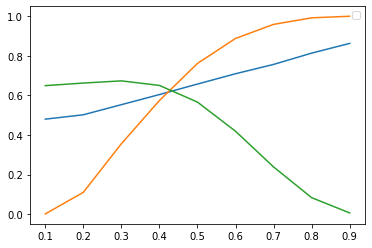

No handles with labels found to put in legend.


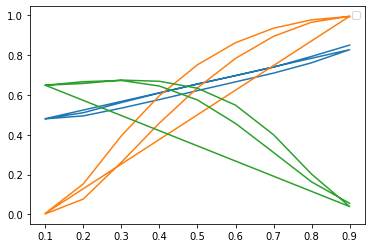

No handles with labels found to put in legend.


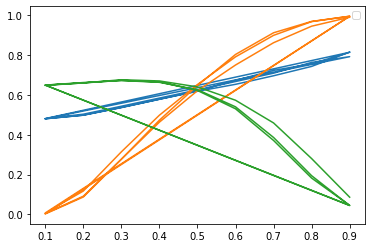

No handles with labels found to put in legend.


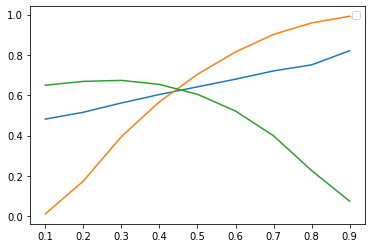

In [ ]:
# Выводим графики метрик в зависимости от threashold для лучших ботов
last_bots = test_bot_result['bot'].unique()[-4:]
for bot in last_bots:
  plt.plot(test_bot_result[test_bot_result['bot']==bot]['threashold'], test_bot_result[test_bot_result['bot']==bot][['precision','specificity', 'f1']])
  plt.legend()
  plt.show()

In [ ]:
test_bot_result['diff'] = test_bot_result['tp'] - test_bot_result['fp']

In [ ]:
# Выбираем бота с лучшей разницей tp - fp в диапазоне treashold 0.4 - 0.6
test_bot_result[(test_bot_result['threashold'] >= 0.4) & (test_bot_result['threashold'] <= 0.6)].sort_values('diff')

bot   max_auc  ...     tp  diff
221  [1, 6, 1, 0, 0.2, 1, 0, 3, 1, 1, 0.6, 1, 0, 3,...  0.676923  ...    313   260
86   [1, 6, 4, 0, 0.2, 1, 0, 7, 0, 0, 0.3, 0, 0, 7,...  0.669154  ...    774   601
220  [1, 6, 1, 0, 0.2, 1, 0, 3, 1, 1, 0.6, 1, 0, 3,...  0.676923  ...    948   745
85   [1, 6, 4, 0, 0.2, 1, 0, 7, 0, 0, 0.3, 0, 0, 7,...  0.669154  ...   1604  1124
219  [1, 6, 1, 0, 0.2, 1, 0, 3, 1, 1, 0.6, 1, 0, 3,...  0.676923  ...   2344  1656
..                                                 ...       ...  ...    ...   ...
265  [1, 6, 1, 0, 0.2, 1, 0, 7, 1, 1, 0.6, 1, 0, 3,...  0.675223  ...  15918  6388
346  [1, 4, 1, 0, 0.2, 1, 0, 7, 1, 1, 0.6, 1, 0, 3,...  0.680013  ...  14482  6391
310  [1, 6, 1, 0, 0.2, 1, 0, 7, 1, 1, 0.6, 1, 0, 3,...  0.673048  ...  16366  6401
229  [1, 6, 1, 0, 0.2, 1, 0, 3, 1, 1, 0.6, 1, 0, 3,...  0.675590  ...  16113  6432
274  [1, 6, 1, 0, 0.2, 1, 0, 7, 1, 1, 0.6, 1, 0, 3,...  0.680517  ...  14916  6435

[120 rows x 12 columns]

# Создаем модель down с лучшим ботом

In [ ]:
bot = test_bot_result[(test_bot_result['threashold'] >= 0.4) & (test_bot_result['threashold'] <= 0.6)].sort_values('diff').iloc[-1,0]
bot

'[1, 6, 1, 0, 0.2, 1, 0, 7, 1, 1, 0.6, 1, 0, 3, 2, 0, 0.4, 0, 5, 4, 1, 0, 2, 1, 4, 11, 4, 1, 2, 1, 6, 3, 1, 1, 2, 1, 6, 10, 3, 0, 2, 1, 6, 8, 0, 1, 2]'

In [ ]:
# Создаем модель down
max_conv = 5  #  Maximim number of Conv layers in model
max_dense = 2  # Maximum number of Dense layers in model
max_lstm = 0  # Maximum nuber of LSTM layers in model
bot = [1, 6, 1, 0, 0.2, 1, 0, 7, 1, 1, 0.6, 1, 0, 3, 2, 0, 0.4, 0, 5, 4, 1, 0, 2, 1, 4, 11, 4, 1, 2, 1, 6, 3, 1, 1, 2, 1, 6, 10, 3, 0, 2, 1, 6, 8, 0, 1, 2]
model_down = create_model_reg(bot)

Epoch 1/1000
485/485 [==============================] - 25s 21ms/step - loss: 0.6845 - auc: 0.6063 - val_loss: 0.7409 - val_auc: 0.6075
Epoch 2/1000
485/485 [==============================] - 10s 20ms/step - loss: 0.6581 - auc: 0.6192 - val_loss: 0.6764 - val_auc: 0.6019
Epoch 3/1000
485/485 [==============================] - 10s 20ms/step - loss: 0.6576 - auc: 0.6202 - val_loss: 0.6786 - val_auc: 0.6038
Epoch 4/1000
485/485 [==============================] - 10s 20ms/step - loss: 0.6566 - auc: 0.6230 - val_loss: 0.6764 - val_auc: 0.6032
Epoch 5/1000
485/485 [==============================] - 10s 20ms/step - loss: 0.8344 - auc: 0.5912 - val_loss: 0.6751 - val_auc: 0.6044
Epoch 6/1000
485/485 [==============================] - 10s 20ms/step - loss: 0.6544 - auc: 0.6267 - val_loss: 0.6764 - val_auc: 0.6022
Epoch 7/1000
485/485 [==============================] - 10s 20ms/step - loss: 0.6572 - auc: 0.6231 - val_loss: 0.6748 - val_auc: 0.6043
Epoch 8/1000
485/485 [==========================

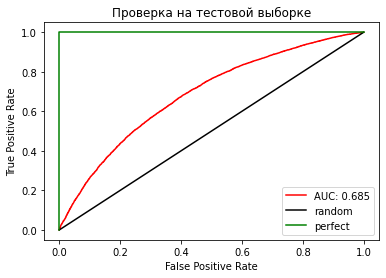

[0 0 0 ... 0 0 0]
[1 0 1 ... 0 1 0]
tn: 26388 fp: 1207 fn: 22006 tp: 3307
              precision    recall  f1-score   support

           0       0.55      0.96      0.69     27595
           1       0.73      0.13      0.22     25313

    accuracy                           0.56     52908
   macro avg       0.64      0.54      0.46     52908
weighted avg       0.63      0.56      0.47     52908


Positive 29695 Negative 23213 Accuracy 56.13%



In [ ]:
model_down.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=1e-2),  metrics=[AUC(name="auc")])

#Запускаем обучение
history = model_down.fit(train_datagen_down, 
                    epochs=1000,
                    verbose=1, 
                    validation_data=val_datagen_down,
                    callbacks=[reduce_lr, early_stop],
                    )

model_name = f'{file_name}_down'  #{time.strftime("%y-%m-%d-%H-%M", time.localtime(time.time()))}'
model_down.save(f'/content/drive/MyDrive/Colab Notebooks/Dipl/Models/{model_name}.h5')

check_model(model_down, x_test_down, x_test_down)

# Тест модели

In [ ]:
# Загружаем модели
model = load_model('/content/drive/MyDrive/Colab Notebooks/Dipl/Models/Trading_NET_v3_1_21-05-12-20-08.h5')
model_down = load_model('/content/drive/MyDrive/Colab Notebooks/Dipl/Models/Trading_NET_v3_3_down.h5')

100%|██████████| 5077/5077 [08:35<00:00,  9.84it/s]


total_trades 313
positive_trades_ratio 0.6070287539936102 positive_trades 190
negative_trades_ratio 0.3929712460063898 negative_trades 123
draw_down -14.280000000000001
max_profit 11.769999999999982
profit_ratio 0.88
total_return:  55501.66
trade_accuracy 55487.38
buy_hold_result 137094.59
buy_hold_result % 137.09458999999998


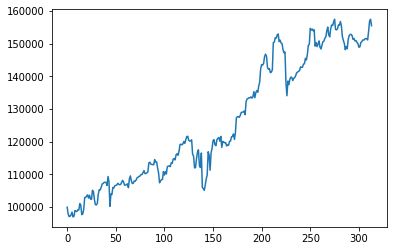

(55487.38, 0.88, 313)

In [ ]:
# Тест моделей и стратегии
test_model(model, model_down)